In [1]:
# =============================================================================
# CELDA 1.1: CONFIGURACIÓN
# =============================================================================

import pandas as pd
import numpy as np
import pyreadstat
import os
import glob
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import ConfirmatoryFactorAnalyzer, FactorAnalyzer

# --- RUTAS ---
CARPETA_RAW = r"G:\Mi unidad\Proyectos\IPA27_project\data\raw\cis\barómetro"
CARPETA_OUTPUT = r"G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro"
PATH_ASSETS = r"G:\Mi unidad\Proyectos\IPA27_project\results\paper_assets"

# Crear carpetas si no existen
os.makedirs(CARPETA_OUTPUT, exist_ok=True)
os.makedirs(PATH_ASSETS, exist_ok=True)

# --- CÓDIGOS POLÍTICOS (desconfianza) ---
CODIGOS_POLITICOS = {
    11: "La corrupción y el fraude",
    13: "El mal comportamiento de los/as políticos/as",
    24: "El Gobierno",
    50: "Lo que hacen los partidos políticos",
    51: "Los problemas políticos en general"
}

# --- CÓDIGOS MATERIALES (para ajuste crowding-out) ---
CODIGOS_MATERIALES = {
    1:  "El paro",
    6:  "La sanidad",
    7:  "La vivienda",
    8:  "La crisis económica, los problemas económicos",
    9:  "Los problemas con la calidad del empleo",
    12: "Las pensiones"
}

# --- PONDERACIONES POR POSICIÓN ---
PESO_POSICION = {1: 3, 2: 2, 3: 1}

# --- ESTUDIOS A EXCLUIR ---
ESTUDIOS_EXCLUIR = [3468]

# --- VARIABLES A IMPORTAR ---
VARS_PROBLEMAS = ["PESPANNA1", "PESPANNA2", "PESPANNA3"]
VARS_ANCLAJE = ["PREFPTE", "PROBVOTO", "CERCESSION", "CERCANIA"]
VARS_GEO = ["CCAA", "PROV", "MUN"]
VARS_ID = ["ESTU", "CUES"]

print("✅ Configuración cargada")
print(f"   📁 Carpeta raw: {CARPETA_RAW}")
print(f"   📁 Carpeta output: {CARPETA_OUTPUT}")
print(f"   📁 Carpeta assets: {PATH_ASSETS}")


c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


✅ Configuración cargada
   📁 Carpeta raw: G:\Mi unidad\Proyectos\IPA27_project\data\raw\cis\barómetro
   📁 Carpeta output: G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro
   📁 Carpeta assets: G:\Mi unidad\Proyectos\IPA27_project\results\paper_assets


In [2]:
# =============================================================================
# CELDA 1.2: CARGA DE MICRODATOS CON MAPEO V5 + CACHÉ INCREMENTAL
# =============================================================================

# --- CONFIGURACIÓN DE CACHÉ ---
CARPETA_CACHE = r"G:\Mi unidad\Proyectos\IPA27_project\data\raw\cis\barómetro\microdatoscompleto"
ARCHIVO_PARQUET = os.path.join(CARPETA_CACHE, "microdatos.parquet")
os.makedirs(CARPETA_CACHE, exist_ok=True)

# Cargar el mapeo
df_mapeo = pd.read_csv(os.path.join(CARPETA_RAW, '_mapeo_variables_v5.csv'))

# Convertir a diccionario {estudio: {var_original: var_estandar}}
def crear_diccionario_renombrado(df_mapeo):
    mapeo_dict = {}
    
    for _, row in df_mapeo.iterrows():
        estudio = int(row['Estudio'])
        renombrar = {}
        
        # Variables de problemas España
        for i in [1, 2, 3]:
            col = f'VAR_ESPANNA{i}'
            if pd.notna(row.get(col)) and row[col] != f'PESPANNA{i}':
                renombrar[row[col]] = f'PESPANNA{i}'
        
        # Variables de anclaje
        anclaje_map = {
            'VAR_PREFPTE': 'PREFPTE',
            'VAR_PROBVOTO': 'PROBVOTO', 
            'VAR_CERCANIA': 'CERCANIA',
            'VAR_SIMPATIA': 'SIMPATIA',
            'VAR_ESCIDEOL': 'ESCIDEOL'
        }
        
        for col_mapeo, var_estandar in anclaje_map.items():
            if col_mapeo in row and pd.notna(row.get(col_mapeo)):
                if row[col_mapeo] != var_estandar:
                    renombrar[row[col_mapeo]] = var_estandar
        
        mapeo_dict[estudio] = renombrar
    
    return mapeo_dict

MAPEO_RENOMBRADO = crear_diccionario_renombrado(df_mapeo)


def cargar_microdatos_v2(carpeta, mapeo_renombrado, estudios_excluir=None, estudios_a_cargar=None):
    """
    Carga archivos .sav usando el mapeo de variables.
    Si estudios_a_cargar es None, carga todos. Si no, carga solo los especificados.
    """
    estudios_excluir = estudios_excluir or []
    
    archivos_sav = sorted(set(
        glob.glob(os.path.join(carpeta, '**/*.sav'), recursive=True) +
        glob.glob(os.path.join(carpeta, '**/*.SAV'), recursive=True)
    ))
    
    # Filtrar por estudios_a_cargar si se especifica
    if estudios_a_cargar is not None:
        archivos_sav = [
            f for f in archivos_sav 
            if int(re.sub(r'[^0-9]', '', os.path.basename(f).replace('.sav', '').replace('.SAV', ''))) in estudios_a_cargar
        ]
    
    print(f"📂 Procesando {len(archivos_sav)} archivos .sav")
    
    dfs = []
    errores = []
    
    # Variables finales que queremos
    vars_finales = ['ESTU', 'CUES', 'CCAA', 'PROV', 'MUN',
                    'PESPANNA1', 'PESPANNA2', 'PESPANNA3',
                    'PREFPTE', 'PROBVOTO', 'CERCANIA', 'SIMPATIA', 'ESCIDEOL', 'PESO']
    
    for archivo in tqdm(archivos_sav, desc="📊 Cargando"):
        nombre = os.path.basename(archivo)
        num_estudio = int(re.sub(r'[^0-9]', '', nombre.replace('.sav', '').replace('.SAV', '')))
        
        if num_estudio in estudios_excluir:
            continue
        
        try:
            df, meta = pyreadstat.read_sav(archivo)
            
            # Eliminar columnas duplicadas
            df = df.loc[:, ~df.columns.duplicated()]
            
            # Renombrar según mapeo
            renombrar = mapeo_renombrado.get(num_estudio, {})
            df = df.rename(columns=renombrar)
            
            # Eliminar duplicados post-renombrado
            df = df.loc[:, ~df.columns.duplicated()]
            
            # Añadir ESTU si no existe
            if 'ESTU' not in df.columns:
                df['ESTU'] = num_estudio
            
            # Seleccionar variables disponibles
            cols_disponibles = [c for c in vars_finales if c in df.columns]
            df = df[cols_disponibles].copy()
            
            dfs.append(df)
            
        except Exception as e:
            errores.append({'Estudio': num_estudio, 'Error': str(e)})
    
    print(f"\n✅ Cargados: {len(dfs)} estudios")
    if errores:
        print(f"⚠️  Errores: {len(errores)}")
        for e in errores[:5]:
            print(f"   - Estudio {e['Estudio']}: {e['Error']}")
    
    if dfs:
        df_consolidado = pd.concat(dfs, ignore_index=True, sort=False)
    else:
        df_consolidado = pd.DataFrame()
    
    return df_consolidado


# --- SISTEMA DE CACHÉ INCREMENTAL ---
print("🔍 Verificando caché de microdatos...")

# 1. Identificar todos los estudios disponibles en carpeta
archivos_sav = sorted(set(
    glob.glob(os.path.join(CARPETA_RAW, '**/*.sav'), recursive=True) +
    glob.glob(os.path.join(CARPETA_RAW, '**/*.SAV'), recursive=True)
))
estudios_disponibles = set()
for archivo in archivos_sav:
    nombre = os.path.basename(archivo)
    num_estudio = int(re.sub(r'[^0-9]', '', nombre.replace('.sav', '').replace('.SAV', '')))
    if num_estudio not in ESTUDIOS_EXCLUIR:
        estudios_disponibles.add(num_estudio)

print(f"   Estudios disponibles en carpeta: {len(estudios_disponibles)}")

# 2. Verificar qué estudios ya están en caché
if os.path.exists(ARCHIVO_PARQUET):
    df_cache = pd.read_parquet(ARCHIVO_PARQUET)
    estudios_en_cache = set(df_cache['ESTU'].unique())
    print(f"   Estudios ya en caché: {len(estudios_en_cache)}")
    
    # 3. Identificar estudios nuevos
    estudios_nuevos = estudios_disponibles - estudios_en_cache
    
    if estudios_nuevos:
        print(f"   🆕 Estudios nuevos detectados: {len(estudios_nuevos)}")
        print(f"      {sorted(estudios_nuevos)}")
        
        # Cargar solo los nuevos
        df_nuevos = cargar_microdatos_v2(CARPETA_RAW, MAPEO_RENOMBRADO, ESTUDIOS_EXCLUIR, estudios_nuevos)
        
        # Combinar con caché
        df_micro = pd.concat([df_cache, df_nuevos], ignore_index=True, sort=False)
        print(f"   ✅ Combinado: {len(df_cache):,} (caché) + {len(df_nuevos):,} (nuevos) = {len(df_micro):,} filas")
    else:
        print(f"   ✅ No hay estudios nuevos, usando caché")
        df_micro = df_cache
else:
    print(f"   📦 Caché no existe, cargando todos los estudios por primera vez...")
    df_micro = cargar_microdatos_v2(CARPETA_RAW, MAPEO_RENOMBRADO, ESTUDIOS_EXCLUIR)

# 4. Rellenar PESO faltante con 1
if 'PESO' in df_micro.columns:
    df_micro['PESO'] = df_micro['PESO'].fillna(1)
else:
    df_micro['PESO'] = 1

# 5. Guardar caché actualizado
print(f"\n💾 Guardando caché en {ARCHIVO_PARQUET}...")
df_micro.to_parquet(ARCHIVO_PARQUET, index=False, compression='snappy')
print(f"   ✅ Guardado exitosamente")

# --- REPORTE FINAL ---
print(f"\n📊 Dataset consolidado:")
print(f"   Filas: {len(df_micro):,}")
print(f"   Columnas: {df_micro.columns.tolist()}")
print(f"   Estudios únicos: {df_micro['ESTU'].nunique()}")

# Verificar cobertura de variables
print(f"\n🔍 Cobertura de variables (% filas no nulas):")
for col in ['PESPANNA1', 'PESPANNA2', 'PESPANNA3', 'PREFPTE', 'PROBVOTO', 'CERCANIA', 'SIMPATIA', 'ESCIDEOL']:
    if col in df_micro.columns:
        pct = df_micro[col].notna().mean() * 100
        print(f"   {col}: {pct:.1f}%")

# Verificar peso
print(f"\n⚖️  Variable PESO:")
print(f"   Casos con peso ≠ 1: {(df_micro['PESO'] != 1).sum():,}")
print(f"   Casos con peso = 1: {(df_micro['PESO'] == 1).sum():,}")

# Verificar algunos valores
print(f"\n👀 Muestra de datos:")
print(df_micro[['ESTU', 'PESPANNA1', 'PESPANNA2', 'PESPANNA3', 'PESO']].head(10))

🔍 Verificando caché de microdatos...
   Estudios disponibles en carpeta: 101
   Estudios ya en caché: 101
   ✅ No hay estudios nuevos, usando caché

💾 Guardando caché en G:\Mi unidad\Proyectos\IPA27_project\data\raw\cis\barómetro\microdatoscompleto\microdatos.parquet...
   ✅ Guardado exitosamente

📊 Dataset consolidado:
   Filas: 346,813
   Columnas: ['ESTU', 'CUES', 'CCAA', 'PROV', 'MUN', 'PESPANNA1', 'PESPANNA2', 'PESPANNA3', 'SIMPATIA', 'CERCANIA', 'PROBVOTO', 'PESO', 'ESCIDEOL', 'PREFPTE']
   Estudios únicos: 101

🔍 Cobertura de variables (% filas no nulas):
   PESPANNA1: 100.0%
   PESPANNA2: 99.9%
   PESPANNA3: 99.7%
   PREFPTE: 58.1%
   PROBVOTO: 46.0%
   CERCANIA: 80.0%
   SIMPATIA: 39.1%
   ESCIDEOL: 70.0%

⚖️  Variable PESO:
   Casos con peso ≠ 1: 221,972
   Casos con peso = 1: 124,841

👀 Muestra de datos:
     ESTU  PESPANNA1  PESPANNA2  PESPANNA3  PESO
0  3124.0       13.0        1.0       33.0   1.0
1  3124.0        1.0       11.0       33.0   1.0
2  3124.0       11.0      

In [3]:
# =============================================================================
# CELDA 1.3: DICCIONARIO DE CÓDIGOS
# =============================================================================
# Diccionario maestro basado en el cuestionario más reciente (3489)
# Fuente: cuestionario CIS barómetro diciembre 2024
DICT_PROBLEMAS = {
    1:  'El paro',
    3:  'Inseguridad ciudadana',
    6:  'La sanidad',
    7:  'La vivienda',
    8:  'La crisis económica, los problemas económicos',
    9:  'Los problemas con la calidad del empleo',
    11: 'La corrupción y el fraude',
    12: 'Las pensiones',
    13: 'El mal comportamiento de los/as políticos/as',
    18: 'La inmigración',
    20: 'Problemas de la juventud: falta de apoyo y oportunidades',
    22: 'La educación',
    23: 'El medio ambiente',
    24: 'El Gobierno',
    42: 'La subida de las tarifas energéticas',
    50: 'Lo que hacen los partidos políticos',
    51: 'Los problemas políticos en general',
    58: 'Desigualdades: de género, clase, pobreza',
    77: 'Desinformación, manipulación y bulos',
    80: 'El cambio climático',
    82: 'Problemas de escasez de agua, sequía',
    # Códigos especiales
    96: 'Otro',
    97: 'Ninguno',
    98: 'N.S.',
    99: 'N.C.'
}

# Verificar qué códigos aparecen en los datos
codigos_datos = set()
for col in ['PESPANNA1', 'PESPANNA2', 'PESPANNA3']:
    codigos_datos.update(df_micro[col].dropna().unique())
codigos_datos = sorted([int(c) for c in codigos_datos if pd.notna(c)])

print("📋 Códigos encontrados en los datos:")
print(f"   Total: {len(codigos_datos)}")

# Identificar códigos sin etiqueta
sin_etiqueta = [c for c in codigos_datos if c not in DICT_PROBLEMAS]
if sin_etiqueta:
    print(f"\n⚠️ Códigos sin etiqueta en el diccionario:")
    print(f"   {sin_etiqueta}")
    print("   (Pueden ser códigos antiguos que ya no se usan)")

# Mostrar frecuencia de códigos principales (PONDERADO)
print(f"\n📊 Frecuencia de códigos ponderada (top 20):")
freq = df_micro.groupby('PESPANNA1')['PESO'].sum().sort_values(ascending=False).head(20)
for codigo, peso_total in freq.items():
    etiqueta = DICT_PROBLEMAS.get(int(codigo), '???')
    print(f"   {int(codigo):3d}: {peso_total:8,.0f} ({etiqueta})")

📋 Códigos encontrados en los datos:
   Total: 101

⚠️ Códigos sin etiqueta en el diccionario:
   [2, 4, 5, 10, 14, 15, 16, 17, 19, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 83, 88, 89, 90, 91, 92, 94, 95, 301, 451, 491, 996, 997, 998, 999]
   (Pueden ser códigos antiguos que ya no se usan)

📊 Frecuencia de códigos ponderada (top 20):
     1:   74,434 (El paro)
     8:   35,903 (La crisis económica, los problemas económicos)
    13:   32,416 (El mal comportamiento de los/as políticos/as)
    51:   25,653 (Los problemas políticos en general)
    11:   22,213 (La corrupción y el fraude)
    24:   20,105 (El Gobierno)
    53:   16,538 (???)
     7:   10,651 (La vivienda)
     9:    9,187 (Los problemas con la calidad del empleo)
    46:    8,147 (???)
    50:    7,979 (Lo que hacen los partidos políticos)
     6:    7,527 (La 

In [4]:
# =============================================================================
# CELDA 1.4: DEFINICIÓN DE CATEGORÍAS POLÍTICAS Y MATERIALES
# =============================================================================
# --- CÓDIGOS POLÍTICOS (desconfianza) ---
# Estos códigos capturan la dimensión de desafección/desconfianza política
CODIGOS_POLITICOS = {
    11: 'La corrupción y el fraude',
    13: 'El mal comportamiento de los/as políticos/as',
    24: 'El Gobierno',
    50: 'Lo que hacen los partidos políticos',
    51: 'Los problemas políticos en general'
}

# --- CÓDIGOS MATERIALES (para ajuste crowding-out) ---
# Estos problemas "compiten" por espacio en la agenda
CODIGOS_MATERIALES = {
    1:  'El paro',
    6:  'La sanidad',
    7:  'La vivienda',
    8:  'La crisis económica, los problemas económicos',
    9:  'Los problemas con la calidad del empleo',
    12: 'Las pensiones'
}

# --- CÓDIGOS ESPECIALES (excluir del análisis) ---
CODIGOS_EXCLUIR = {97, 98, 99}  # Ninguno, NS, NC

print("🏷️ CATEGORÍAS DEFINIDAS:")
print("="*60)

print("\n🔴 CÓDIGOS POLÍTICOS (desconfianza):")
for cod, etiq in CODIGOS_POLITICOS.items():
    # Contar frecuencia PONDERADA
    peso_total = df_micro.loc[df_micro['PESPANNA1'] == cod, 'PESO'].sum()
    print(f"   {cod:3d}: {etiq} (peso={peso_total:,.0f})")

print("\n🔵 CÓDIGOS MATERIALES (crowding-out):")
for cod, etiq in CODIGOS_MATERIALES.items():
    peso_total = df_micro.loc[df_micro['PESPANNA1'] == cod, 'PESO'].sum()
    print(f"   {cod:3d}: {etiq} (peso={peso_total:,.0f})")

# Verificar que no hay solapamiento
solapados = set(CODIGOS_POLITICOS.keys()) & set(CODIGOS_MATERIALES.keys())
if solapados:
    print(f"\n⚠️ ALERTA: Códigos en ambas categorías: {solapados}")
else:
    print(f"\n✅ Sin solapamiento entre categorías")

# Calcular cobertura de las categorías (PONDERADO)
peso_total_resp = df_micro.loc[df_micro['PESPANNA1'].notna(), 'PESO'].sum()
peso_politicos = df_micro.loc[df_micro['PESPANNA1'].isin(CODIGOS_POLITICOS.keys()), 'PESO'].sum()
peso_materiales = df_micro.loc[df_micro['PESPANNA1'].isin(CODIGOS_MATERIALES.keys()), 'PESO'].sum()
peso_excluir = df_micro.loc[df_micro['PESPANNA1'].isin(CODIGOS_EXCLUIR), 'PESO'].sum()
peso_otros = peso_total_resp - peso_politicos - peso_materiales - peso_excluir

print(f"\n📊 Cobertura ponderada en PESPANNA1:")
print(f"   Políticos:  {peso_politicos:,.0f} ({peso_politicos/peso_total_resp*100:.1f}%)")
print(f"   Materiales: {peso_materiales:,.0f} ({peso_materiales/peso_total_resp*100:.1f}%)")
print(f"   Otros:      {peso_otros:,.0f} ({peso_otros/peso_total_resp*100:.1f}%)")

🏷️ CATEGORÍAS DEFINIDAS:

🔴 CÓDIGOS POLÍTICOS (desconfianza):
    11: La corrupción y el fraude (peso=22,213)
    13: El mal comportamiento de los/as políticos/as (peso=32,416)
    24: El Gobierno (peso=20,105)
    50: Lo que hacen los partidos políticos (peso=7,979)
    51: Los problemas políticos en general (peso=25,653)

🔵 CÓDIGOS MATERIALES (crowding-out):
     1: El paro (peso=74,434)
     6: La sanidad (peso=7,527)
     7: La vivienda (peso=10,651)
     8: La crisis económica, los problemas económicos (peso=35,903)
     9: Los problemas con la calidad del empleo (peso=9,187)
    12: Las pensiones (peso=2,290)

✅ Sin solapamiento entre categorías

📊 Cobertura ponderada en PESPANNA1:
   Políticos:  108,366 (31.2%)
   Materiales: 139,992 (40.4%)
   Otros:      92,670 (26.7%)


In [5]:
# =============================================================================
# CELDA 2.1: IDENTIFICACIÓN DE MENCIONES POLÍTICAS
# =============================================================================
def es_politico(codigo):
    """Devuelve 1 si el código es político, 0 si no, NaN si es NS/NC."""
    if pd.isna(codigo):
        return np.nan
    codigo = int(codigo)
    if codigo in CODIGOS_EXCLUIR:
        return np.nan
    return 1 if codigo in CODIGOS_POLITICOS else 0

def es_material(codigo):
    """Devuelve 1 si el código es material, 0 si no, NaN si es NS/NC."""
    if pd.isna(codigo):
        return np.nan
    codigo = int(codigo)
    if codigo in CODIGOS_EXCLUIR:
        return np.nan
    return 1 if codigo in CODIGOS_MATERIALES else 0

# Crear indicadores binarios para cada posición
for i in [1, 2, 3]:
    col_orig = f'PESPANNA{i}'
    col_pol = f'ES_POLITICO_{i}'
    col_mat = f'ES_MATERIAL_{i}'
    
    df_micro[col_pol] = df_micro[col_orig].apply(es_politico)
    df_micro[col_mat] = df_micro[col_orig].apply(es_material)

# Verificar (PONDERADO)
print("📊 IDENTIFICACIÓN DE MENCIONES POLÍTICAS")
print("="*60)

print("\n🔴 Menciones políticas por posición (ponderado):")
for i in [1, 2, 3]:
    col = f'ES_POLITICO_{i}'
    peso_pol = df_micro.loc[df_micro[col] == 1, 'PESO'].sum()
    peso_total = df_micro.loc[df_micro[col].notna(), 'PESO'].sum()
    pct = peso_pol / peso_total * 100 if peso_total > 0 else 0
    print(f"   Posición {i}: {peso_pol:,.0f} / {peso_total:,.0f} ({pct:.1f}%)")

print("\n🔵 Menciones materiales por posición (ponderado):")
for i in [1, 2, 3]:
    col = f'ES_MATERIAL_{i}'
    peso_mat = df_micro.loc[df_micro[col] == 1, 'PESO'].sum()
    peso_total = df_micro.loc[df_micro[col].notna(), 'PESO'].sum()
    pct = peso_mat / peso_total * 100 if peso_total > 0 else 0
    print(f"   Posición {i}: {peso_mat:,.0f} / {peso_total:,.0f} ({pct:.1f}%)")

# Muestra de datos
print("\n👀 Muestra de datos con indicadores:")
cols_muestra = ['ESTU', 'PESPANNA1', 'ES_POLITICO_1', 'ES_MATERIAL_1', 
                'PESPANNA2', 'ES_POLITICO_2', 'ES_MATERIAL_2']
print(df_micro[cols_muestra].head(10).to_string(index=False))

📊 IDENTIFICACIÓN DE MENCIONES POLÍTICAS

🔴 Menciones políticas por posición (ponderado):
   Posición 1: 108,366 / 341,028 (31.8%)
   Posición 2: 60,645 / 317,918 (19.1%)
   Posición 3: 37,630 / 261,627 (14.4%)

🔵 Menciones materiales por posición (ponderado):
   Posición 1: 139,992 / 341,028 (41.1%)
   Posición 2: 138,044 / 317,918 (43.4%)
   Posición 3: 88,212 / 261,627 (33.7%)

👀 Muestra de datos con indicadores:
  ESTU  PESPANNA1  ES_POLITICO_1  ES_MATERIAL_1  PESPANNA2  ES_POLITICO_2  ES_MATERIAL_2
3124.0       13.0            1.0            0.0        1.0            0.0            1.0
3124.0        1.0            0.0            1.0       11.0            1.0            0.0
3124.0       11.0            1.0            0.0        1.0            0.0            1.0
3124.0        1.0            0.0            1.0       28.0            0.0            0.0
3124.0       98.0            NaN            NaN       99.0            NaN            NaN
3124.0       32.0            0.0            0.0

In [6]:
# =============================================================================
# CELDA 2.2: PONDERACIÓN POR POSICIÓN
# =============================================================================
# Pesos: 1º problema pesa más que 2º, que pesa más que 3º
PESO_POSICION = {1: 3, 2: 2, 3: 1}

print("⚖️ PONDERACIÓN POR POSICIÓN")
print("="*60)
print(f"   1º problema: peso = {PESO_POSICION[1]}")
print(f"   2º problema: peso = {PESO_POSICION[2]}")
print(f"   3º problema: peso = {PESO_POSICION[3]}")
print(f"   Máximo posible: {sum(PESO_POSICION.values())} puntos")

# Calcular score ponderado político
df_micro['SCORE_POLITICO_POND'] = (
    df_micro['ES_POLITICO_1'].fillna(0) * PESO_POSICION[1] +
    df_micro['ES_POLITICO_2'].fillna(0) * PESO_POSICION[2] +
    df_micro['ES_POLITICO_3'].fillna(0) * PESO_POSICION[3]
)

# Calcular score ponderado material
df_micro['SCORE_MATERIAL_POND'] = (
    df_micro['ES_MATERIAL_1'].fillna(0) * PESO_POSICION[1] +
    df_micro['ES_MATERIAL_2'].fillna(0) * PESO_POSICION[2] +
    df_micro['ES_MATERIAL_3'].fillna(0) * PESO_POSICION[3]
)

# Calcular también versión simple (sin ponderar) para comparar
df_micro['N_MENCIONES_POLITICAS'] = (
    df_micro['ES_POLITICO_1'].fillna(0) +
    df_micro['ES_POLITICO_2'].fillna(0) +
    df_micro['ES_POLITICO_3'].fillna(0)
)

df_micro['N_MENCIONES_MATERIALES'] = (
    df_micro['ES_MATERIAL_1'].fillna(0) +
    df_micro['ES_MATERIAL_2'].fillna(0) +
    df_micro['ES_MATERIAL_3'].fillna(0)
)

# Verificar distribución (PONDERADO)
print("\n📊 Distribución del score político ponderado (población ponderada):")
dist_score_pol = df_micro.groupby('SCORE_POLITICO_POND')['PESO'].sum().sort_index()
for score, peso in dist_score_pol.items():
    print(f"   Score {score}: {peso:,.0f}")

print("\n📊 Distribución del nº de menciones políticas (población ponderada):")
dist_n_menciones = df_micro.groupby('N_MENCIONES_POLITICAS')['PESO'].sum().sort_index()
for n, peso in dist_n_menciones.items():
    print(f"   {int(n)} menciones: {peso:,.0f}")

⚖️ PONDERACIÓN POR POSICIÓN
   1º problema: peso = 3
   2º problema: peso = 2
   3º problema: peso = 1
   Máximo posible: 6 puntos

📊 Distribución del score político ponderado (población ponderada):
   Score 0.0: 164,769
   Score 1.0: 27,064
   Score 2.0: 42,275
   Score 3.0: 93,893
   Score 4.0: 4,779
   Score 5.0: 12,584
   Score 6.0: 1,449

📊 Distribución del nº de menciones políticas (población ponderada):
   0 menciones: 164,769
   1 menciones: 158,894
   2 menciones: 21,701
   3 menciones: 1,449


In [7]:
# =============================================================================
# CELDA 2.3: SCORE INDIVIDUAL BRUTO
# =============================================================================
# El score bruto es el ponderado, normalizado a escala 0-100
MAX_SCORE = sum(PESO_POSICION.values())  # 6 puntos

df_micro['SCORE_POLITICO_BRUTO'] = (df_micro['SCORE_POLITICO_POND'] / MAX_SCORE) * 100
df_micro['SCORE_MATERIAL_BRUTO'] = (df_micro['SCORE_MATERIAL_POND'] / MAX_SCORE) * 100

print("📊 SCORE INDIVIDUAL BRUTO (escala 0-100)")
print("="*60)

# Función helper para mediana ponderada
def weighted_median(values, weights):
    """Calcula la mediana ponderada"""
    df_temp = pd.DataFrame({'val': values, 'w': weights}).dropna()
    df_temp = df_temp.sort_values('val')
    cumsum = df_temp['w'].cumsum()
    cutoff = df_temp['w'].sum() / 2.0
    return df_temp['val'][cumsum >= cutoff].iloc[0]

# Función helper para std ponderada
def weighted_std(values, weights):
    """Calcula la desviación estándar ponderada"""
    average = np.average(values, weights=weights)
    variance = np.average((values - average)**2, weights=weights)
    return np.sqrt(variance)

print("\n🔴 Score político bruto (ponderado):")
score_pol = df_micro['SCORE_POLITICO_BRUTO'].dropna()
peso_pol = df_micro.loc[score_pol.index, 'PESO']
print(f"   Media:    {np.average(score_pol, weights=peso_pol):.2f}")
print(f"   Mediana:  {weighted_median(score_pol, peso_pol):.2f}")
print(f"   Std:      {weighted_std(score_pol, peso_pol):.2f}")
print(f"   Min-Max:  {score_pol.min():.0f} - {score_pol.max():.0f}")

print("\n🔵 Score material bruto (ponderado):")
score_mat = df_micro['SCORE_MATERIAL_BRUTO'].dropna()
peso_mat = df_micro.loc[score_mat.index, 'PESO']
print(f"   Media:    {np.average(score_mat, weights=peso_mat):.2f}")
print(f"   Mediana:  {weighted_median(score_mat, peso_mat):.2f}")
print(f"   Std:      {weighted_std(score_mat, peso_mat):.2f}")
print(f"   Min-Max:  {score_mat.min():.0f} - {score_mat.max():.0f}")

# Evolución temporal rápida (preview) - PONDERADO
print("\n📈 Preview: Media ponderada por estudio (primeros y últimos 5):")
evol = df_micro.groupby('ESTU').apply(
    lambda x: pd.Series({
        'SCORE_POLITICO_BRUTO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                          weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO']),
        'SCORE_MATERIAL_BRUTO': np.average(x['SCORE_MATERIAL_BRUTO'].dropna(), 
                                          weights=x.loc[x['SCORE_MATERIAL_BRUTO'].notna(), 'PESO'])
    })
).round(2)

print("\nPrimeros estudios:")
print(evol.head().to_string())
print("\nÚltimos estudios:")
print(evol.tail().to_string())

# Verificar muestra individual
print("\n👀 Muestra de scores individuales:")
cols_score = ['ESTU', 'PESPANNA1', 'PESPANNA2', 'PESPANNA3', 
              'N_MENCIONES_POLITICAS', 'SCORE_POLITICO_BRUTO', 'PESO']
print(df_micro[cols_score].head(15).to_string(index=False))

📊 SCORE INDIVIDUAL BRUTO (escala 0-100)

🔴 Score político bruto (ponderado):
   Media:    23.26
   Mediana:  16.67
   Std:      25.45
   Min-Max:  0 - 100

🔵 Score material bruto (ponderado):
   Media:    37.69
   Mediana:  33.33
   Std:      29.79
   Min-Max:  0 - 100

📈 Preview: Media ponderada por estudio (primeros y últimos 5):

Primeros estudios:
        SCORE_POLITICO_BRUTO  SCORE_MATERIAL_BRUTO
ESTU                                              
3124.0                 23.62                 48.28
3128.0                 25.91                 47.69
3131.0                 25.35                 47.23
3134.0                 25.61                 46.96
3138.0                 26.10                 45.68

Últimos estudios:
        SCORE_POLITICO_BRUTO  SCORE_MATERIAL_BRUTO
ESTU                                              
3517.0                 30.51                 30.47
3524.0                 25.99                 30.36
3528.0                 23.59                 36.73
3530.0         

In [8]:
# =============================================================================
# CELDA 3.1: DEFINICIÓN DE PRESIÓN DE AGENDA (CROWDING-OUT)
# =============================================================================
# La "presión de agenda" mide cuánto espacio ocupan los problemas materiales
# Cuando es alta, hay menos "hueco" para mencionar problemas políticos

print("📊 PRESIÓN DE AGENDA (CROWDING-OUT)")
print("="*60)

# Calcular presión de agenda por estudio (PONDERADO)
presion_agenda = df_micro.groupby('ESTU').apply(
    lambda x: pd.Series({
        'MEDIA_MATERIAL': np.average(x['SCORE_MATERIAL_BRUTO'].dropna(), 
                                     weights=x.loc[x['SCORE_MATERIAL_BRUTO'].notna(), 'PESO']),
        'MEDIA_POLITICO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                     weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO']),
        'N_MATERIAL': np.average(x['N_MENCIONES_MATERIALES'].dropna(), 
                                weights=x.loc[x['N_MENCIONES_MATERIALES'].notna(), 'PESO']),
        'N_POLITICO': np.average(x['N_MENCIONES_POLITICAS'].dropna(), 
                                weights=x.loc[x['N_MENCIONES_POLITICAS'].notna(), 'PESO'])
    })
).reset_index()

# La presión de agenda es el % de menciones materiales sobre el total de menciones válidas
# Normalizado a escala 0-1
presion_agenda['PRESION_AGENDA'] = presion_agenda['MEDIA_MATERIAL'] / 100

print(f"\n📈 Estadísticas de presión de agenda:")
print(f"   Media:   {presion_agenda['PRESION_AGENDA'].mean():.3f}")
print(f"   Min:     {presion_agenda['PRESION_AGENDA'].min():.3f}")
print(f"   Max:     {presion_agenda['PRESION_AGENDA'].max():.3f}")
print(f"   Std:     {presion_agenda['PRESION_AGENDA'].std():.3f}")

# Correlación entre presión material y score político
corr = presion_agenda['MEDIA_MATERIAL'].corr(presion_agenda['MEDIA_POLITICO'])
print(f"\n🔗 Correlación Material vs Político: {corr:.3f}")
print("   (Negativa = evidencia de crowding-out)")

# Mostrar extremos
print(f"\n📉 Estudios con MAYOR presión material (crisis):")
top_material = presion_agenda.nlargest(5, 'PRESION_AGENDA')
print(top_material[['ESTU', 'MEDIA_MATERIAL', 'MEDIA_POLITICO', 'PRESION_AGENDA']].to_string(index=False))

print(f"\n📈 Estudios con MENOR presión material (bonanza):")
low_material = presion_agenda.nsmallest(5, 'PRESION_AGENDA')
print(low_material[['ESTU', 'MEDIA_MATERIAL', 'MEDIA_POLITICO', 'PRESION_AGENDA']].to_string(index=False))

📊 PRESIÓN DE AGENDA (CROWDING-OUT)

📈 Estadísticas de presión de agenda:
   Media:   0.385
   Min:     0.274
   Max:     0.503
   Std:     0.065

🔗 Correlación Material vs Político: 0.057
   (Negativa = evidencia de crowding-out)

📉 Estudios con MAYOR presión material (crisis):
  ESTU  MEDIA_MATERIAL  MEDIA_POLITICO  PRESION_AGENDA
3247.0       50.256840       21.278615        0.502568
3277.0       50.090067       22.366061        0.500901
3273.0       49.165821       24.467366        0.491658
3162.0       49.040281       22.289808        0.490403
3252.0       48.884779       21.766420        0.488848

📈 Estudios con MENOR presión material (bonanza):
  ESTU  MEDIA_MATERIAL  MEDIA_POLITICO  PRESION_AGENDA
3474.0       27.377343       22.197872        0.273773
3445.0       27.864182       26.866959        0.278642
3441.0       28.419221       24.137094        0.284192
3292.0       28.632920       27.157943        0.286329
3489.0       28.974189       26.968293        0.289742


In [9]:
# =============================================================================
# CELDA 3.2: CÁLCULO DEL AJUSTE POR CROWDING-OUT
# =============================================================================
# Estrategia: Ajustar el score político según el "espacio disponible"
# Score ajustado = Score bruto / (1 - presión_agenda)
# 
# Intuición: Si la presión material es 0.5 (50%), el espacio disponible es 0.5
# Un score bruto de 20 en ese contexto equivale a 40 en condiciones "normales"

# Primero, merge la presión de agenda al dataframe individual
df_micro = df_micro.merge(
    presion_agenda[['ESTU', 'PRESION_AGENDA']], 
    on='ESTU', 
    how='left'
)

# Calcular el "espacio disponible" (1 - presión)
# Añadimos un floor para evitar división por números muy pequeños
FLOOR_ESPACIO = 0.3  # Mínimo 30% de espacio disponible
df_micro['ESPACIO_DISPONIBLE'] = (1 - df_micro['PRESION_AGENDA']).clip(lower=FLOOR_ESPACIO)

# Score ajustado por crowding-out
df_micro['SCORE_POLITICO_AJUSTADO'] = (
    df_micro['SCORE_POLITICO_BRUTO'] / df_micro['ESPACIO_DISPONIBLE']
).clip(upper=100)  # Cap en 100

print("📊 AJUSTE POR CROWDING-OUT")
print("="*60)
print(f"\n⚙️ Parámetros:")
print(f"   Floor espacio disponible: {FLOOR_ESPACIO}")
print(f"   Fórmula: Score_ajustado = Score_bruto / max(1 - presion, {FLOOR_ESPACIO})")

# Estadísticas PONDERADAS
score_bruto = df_micro['SCORE_POLITICO_BRUTO'].dropna()
peso_bruto = df_micro.loc[score_bruto.index, 'PESO']
score_ajust = df_micro['SCORE_POLITICO_AJUSTADO'].dropna()
peso_ajust = df_micro.loc[score_ajust.index, 'PESO']

print(f"\n🔴 Score político BRUTO (ponderado):")
print(f"   Media:   {np.average(score_bruto, weights=peso_bruto):.2f}")
print(f"   Std:     {weighted_std(score_bruto, peso_bruto):.2f}")

print(f"\n🟠 Score político AJUSTADO (ponderado):")
print(f"   Media:   {np.average(score_ajust, weights=peso_ajust):.2f}")
print(f"   Std:     {weighted_std(score_ajust, peso_ajust):.2f}")

# Comparar evolución bruto vs ajustado (PONDERADO por estudio)
evol_comparada = df_micro.groupby('ESTU').apply(
    lambda x: pd.Series({
        'SCORE_POLITICO_BRUTO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                          weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO']),
        'SCORE_POLITICO_AJUSTADO': np.average(x['SCORE_POLITICO_AJUSTADO'].dropna(), 
                                             weights=x.loc[x['SCORE_POLITICO_AJUSTADO'].notna(), 'PESO']),
        'PRESION_AGENDA': x['PRESION_AGENDA'].iloc[0]  # Constante por estudio
    })
).reset_index()

print(f"\n📈 Comparación por estudio (primeros 5):")
print(evol_comparada.head().to_string(index=False))

print(f"\n📈 Comparación por estudio (últimos 5):")
print(evol_comparada.tail().to_string(index=False))

# Diferencia bruto-ajustado (ya no necesita más ponderación)
evol_comparada['DIFERENCIA'] = evol_comparada['SCORE_POLITICO_AJUSTADO'] - evol_comparada['SCORE_POLITICO_BRUTO']

print(f"\n📊 Diferencia (ajustado - bruto):")
print(f"   Media:   {evol_comparada['DIFERENCIA'].mean():.2f}")
print(f"   Min:     {evol_comparada['DIFERENCIA'].min():.2f}")
print(f"   Max:     {evol_comparada['DIFERENCIA'].max():.2f}")

📊 AJUSTE POR CROWDING-OUT

⚙️ Parámetros:
   Floor espacio disponible: 0.3
   Fórmula: Score_ajustado = Score_bruto / max(1 - presion, 0.3)

🔴 Score político BRUTO (ponderado):
   Media:   23.26
   Std:     25.45

🟠 Score político AJUSTADO (ponderado):
   Media:   36.08
   Std:     38.02

📈 Comparación por estudio (primeros 5):
  ESTU  SCORE_POLITICO_BRUTO  SCORE_POLITICO_AJUSTADO  PRESION_AGENDA
3124.0             23.624466                43.286734        0.482772
3128.0             25.914716                47.080374        0.476930
3131.0             25.354682                45.571696        0.472301
3134.0             25.609103                46.090916        0.469612
3138.0             26.100376                45.824641        0.456790

📈 Comparación por estudio (últimos 5):
  ESTU  SCORE_POLITICO_BRUTO  SCORE_POLITICO_AJUSTADO  PRESION_AGENDA
3517.0             30.505801                41.936904        0.304689
3524.0             25.993403                35.950934        0.303606


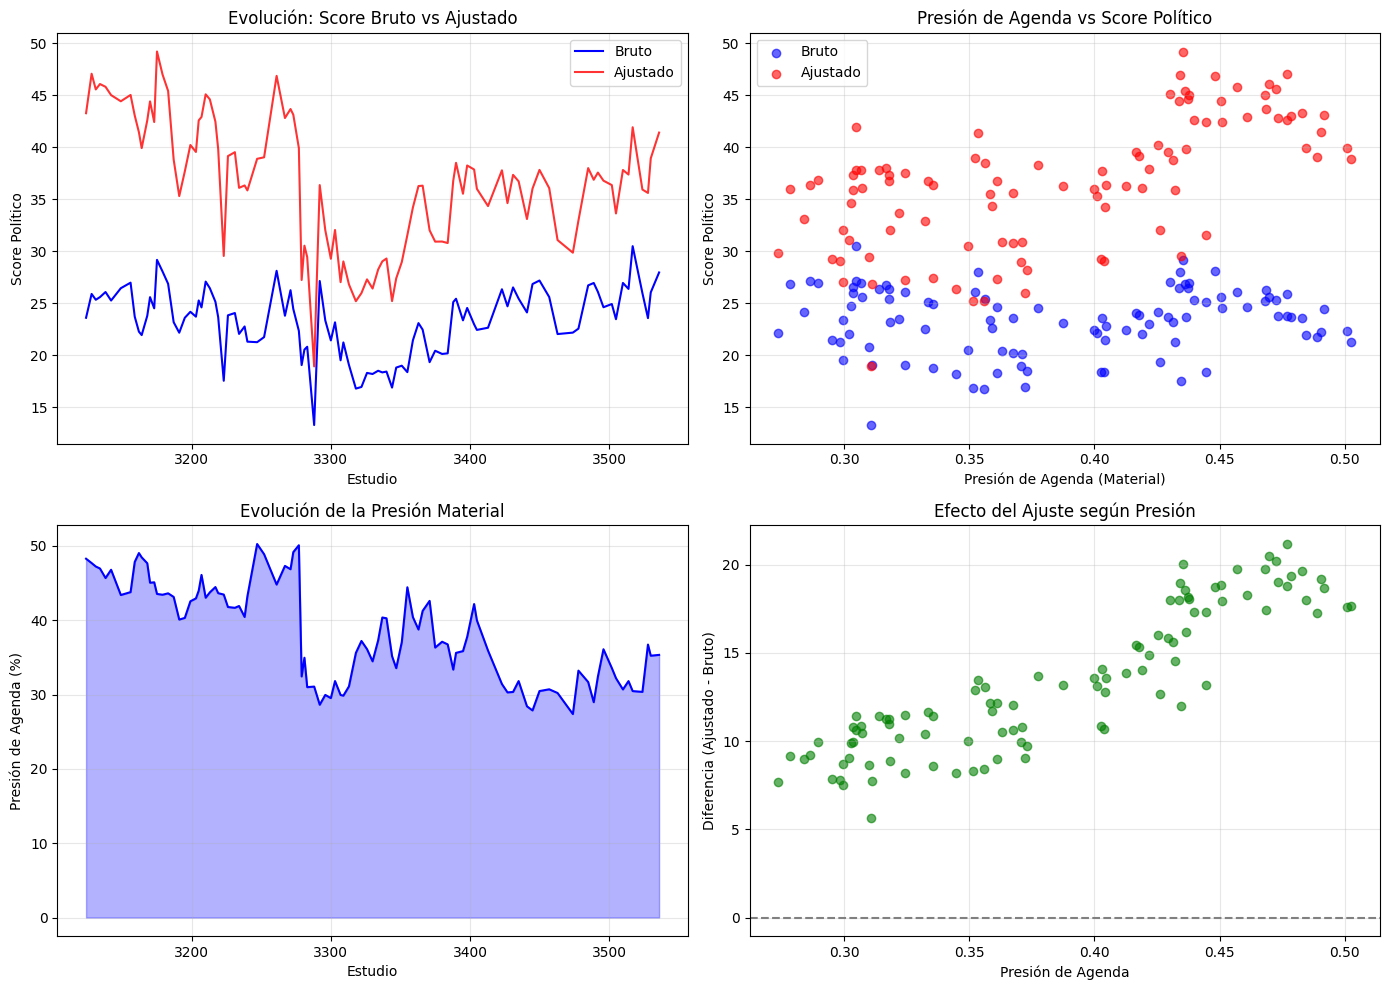


💾 Guardado: validacion_crowdingout.png

🔗 Correlación presión-score:
   Bruto:    0.057
   Ajustado: 0.607
   (El ajuste debería reducir la correlación negativa)


In [10]:
# =============================================================================
# CELDA 3.3: VALIDACIÓN DEL AJUSTE
# =============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Serie temporal: Bruto vs Ajustado
ax1 = axes[0, 0]
ax1.plot(evol_comparada['ESTU'], evol_comparada['SCORE_POLITICO_BRUTO'], 
         'b-', label='Bruto', linewidth=1.5)
ax1.plot(evol_comparada['ESTU'], evol_comparada['SCORE_POLITICO_AJUSTADO'], 
         'r-', label='Ajustado', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Estudio')
ax1.set_ylabel('Score Político')
ax1.set_title('Evolución: Score Bruto vs Ajustado')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Presión de agenda vs Score político bruto
ax2 = axes[0, 1]
ax2.scatter(evol_comparada['PRESION_AGENDA'], evol_comparada['SCORE_POLITICO_BRUTO'], 
            alpha=0.6, c='blue', label='Bruto')
ax2.scatter(evol_comparada['PRESION_AGENDA'], evol_comparada['SCORE_POLITICO_AJUSTADO'], 
            alpha=0.6, c='red', label='Ajustado')
ax2.set_xlabel('Presión de Agenda (Material)')
ax2.set_ylabel('Score Político')
ax2.set_title('Presión de Agenda vs Score Político')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Serie temporal: Presión de agenda
ax3 = axes[1, 0]
ax3.fill_between(evol_comparada['ESTU'], 0, evol_comparada['PRESION_AGENDA']*100, 
                 alpha=0.3, color='blue')
ax3.plot(evol_comparada['ESTU'], evol_comparada['PRESION_AGENDA']*100, 
         'b-', linewidth=1.5)
ax3.set_xlabel('Estudio')
ax3.set_ylabel('Presión de Agenda (%)')
ax3.set_title('Evolución de la Presión Material')
ax3.grid(True, alpha=0.3)

# 4. Diferencia ajustado-bruto vs presión
ax4 = axes[1, 1]
ax4.scatter(evol_comparada['PRESION_AGENDA'], evol_comparada['DIFERENCIA'], 
            alpha=0.6, c='green')
ax4.axhline(y=0, color='gray', linestyle='--')
ax4.set_xlabel('Presión de Agenda')
ax4.set_ylabel('Diferencia (Ajustado - Bruto)')
ax4.set_title('Efecto del Ajuste según Presión')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CARPETA_OUTPUT, 'validacion_crowdingout.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Guardado: validacion_crowdingout.png")

# Correlaciones post-ajuste
corr_bruto = evol_comparada['PRESION_AGENDA'].corr(evol_comparada['SCORE_POLITICO_BRUTO'])
corr_ajustado = evol_comparada['PRESION_AGENDA'].corr(evol_comparada['SCORE_POLITICO_AJUSTADO'])

print(f"\n🔗 Correlación presión-score:")
print(f"   Bruto:    {corr_bruto:.3f}")
print(f"   Ajustado: {corr_ajustado:.3f}")
print(f"   (El ajuste debería reducir la correlación negativa)")

In [11]:
# =============================================================================
# CELDA 3.4: DIAGNÓSTICO DEL OUTLIER Y REVISIÓN DEL AJUSTE
# =============================================================================
# Investigar el estudio 3257
print("🔍 DIAGNÓSTICO DEL OUTLIER")
print("="*60)

estudio_outlier = 3257
datos_outlier = df_micro[df_micro['ESTU'] == estudio_outlier]

print(f"\nEstudio {estudio_outlier}:")
print(f"   N observaciones: {len(datos_outlier)}")
print(f"   PESPANNA1 valores únicos: {datos_outlier['PESPANNA1'].unique()}")
print(f"   Presión agenda: {datos_outlier['PRESION_AGENDA'].iloc[0] if len(datos_outlier) > 0 else 'N/A'}")

# Verificar si está en nuestros datos
if estudio_outlier in df_micro['ESTU'].values:
    print(f"\n   Muestra de datos:")
    print(datos_outlier[['PESPANNA1', 'PESPANNA2', 'PESPANNA3']].head(10))
else:
    print(f"\n   ⚠️ Estudio {estudio_outlier} no está en los microdatos")
    # Buscar el estudio con presión = 0
    est_cero = evol_comparada[evol_comparada['PRESION_AGENDA'] == 0]['ESTU'].values
    print(f"   Estudio(s) con presión = 0: {est_cero}")

# Recalcular excluyendo outliers (NO necesita cambios, usa evol_comparada ya ponderado)
print("\n📊 RECÁLCULO SIN OUTLIERS (presión > 0.1):")
evol_filtrada = evol_comparada[evol_comparada['PRESION_AGENDA'] > 0.1]

corr_bruto_filt = evol_filtrada['PRESION_AGENDA'].corr(evol_filtrada['SCORE_POLITICO_BRUTO'])
corr_ajust_filt = evol_filtrada['PRESION_AGENDA'].corr(evol_filtrada['SCORE_POLITICO_AJUSTADO'])

print(f"   N estudios: {len(evol_filtrada)}")
print(f"   Correlación presión-bruto:    {corr_bruto_filt:.3f}")
print(f"   Correlación presión-ajustado: {corr_ajust_filt:.3f}")

# ¿Qué compite con político y material? (PONDERADO)
print("\n📊 ¿CON QUÉ COMPITEN?")

# Calcular % de menciones "otros" (ni político ni material)
df_micro['ES_OTRO_1'] = ((df_micro['ES_POLITICO_1'] == 0) & 
                         (df_micro['ES_MATERIAL_1'] == 0) & 
                         df_micro['PESPANNA1'].notna() &
                         ~df_micro['PESPANNA1'].isin(CODIGOS_EXCLUIR)).astype(float)

# Calcular % otros por estudio PONDERADO
otros_por_estudio = df_micro.groupby('ESTU').apply(
    lambda x: np.average(x['ES_OTRO_1'].dropna(), 
                        weights=x.loc[x['ES_OTRO_1'].notna(), 'PESO']) * 100
)

print(f"   % 'Otros' en posición 1 ponderado (ni político ni material):")
print(f"   Media: {otros_por_estudio.mean():.1f}%")
print(f"   Min:   {otros_por_estudio.min():.1f}%")
print(f"   Max:   {otros_por_estudio.max():.1f}%")

# ¿Qué códigos son "otros"? (PONDERADO)
print("\n📋 Top códigos 'otros' ponderado (ni político ni material):")
otros_codigos = df_micro[df_micro['ES_OTRO_1'] == 1].groupby('PESPANNA1')['PESO'].sum().sort_values(ascending=False).head(10)

for cod, peso_total in otros_codigos.items():
    etiq = DICT_PROBLEMAS.get(int(cod), '???')
    print(f"   {int(cod):3d}: {peso_total:8,.0f} - {etiq}")

🔍 DIAGNÓSTICO DEL OUTLIER

Estudio 3257:
   N observaciones: 0
   PESPANNA1 valores únicos: []
   Presión agenda: N/A

   ⚠️ Estudio 3257 no está en los microdatos
   Estudio(s) con presión = 0: []

📊 RECÁLCULO SIN OUTLIERS (presión > 0.1):
   N estudios: 101
   Correlación presión-bruto:    0.057
   Correlación presión-ajustado: 0.607

📊 ¿CON QUÉ COMPITEN?
   % 'Otros' en posición 1 ponderado (ni político ni material):
   Media: 25.4%
   Min:   8.2%
   Max:   56.0%

📋 Top códigos 'otros' ponderado (ni político ni material):
    53:   16,538 - ???
    46:    8,147 - ???
    18:    6,141 - La inmigración
    16:    5,501 - ???
    21:    4,299 - ???
    52:    4,126 - ???
    58:    4,092 - Desigualdades: de género, clase, pobreza
    20:    3,848 - Problemas de la juventud: falta de apoyo y oportunidades
    45:    3,806 - ???
    96:    3,618 - Otro


In [12]:
# =============================================================================
# CELDA 3.5: COMPLETAR DICCIONARIO Y LIMPIAR DATOS
# =============================================================================
# Añadir estudio 3257 a exclusiones
ESTUDIOS_EXCLUIR.append(3257)
print(f"📋 Estudios a excluir: {ESTUDIOS_EXCLUIR}")

# Excluir del dataframe
df_micro = df_micro[~df_micro['ESTU'].isin(ESTUDIOS_EXCLUIR)]
print(f"   Filas tras excluir: {len(df_micro):,}")

# Completar el diccionario con códigos históricos
# Estos códigos provienen de barómetros antiguos
DICT_PROBLEMAS_HISTORICO = {
    # Códigos actuales (ya definidos)
    **DICT_PROBLEMAS,
    
    # Códigos históricos (estudios antiguos)
    10: 'Los problemas de índole social',
    14: 'La inseguridad ciudadana (otros)',
    15: 'El terrorismo, ETA',
    16: 'Las infraestructuras',
    17: 'La violencia contra la mujer',
    19: 'Los nacionalismos',
    21: 'Los problemas relacionados con la juventud',
    25: 'La crisis de valores',
    26: 'La Administración de Justicia',
    27: 'Los problemas medioambientales',
    28: 'El funcionamiento de los servicios públicos',
    29: 'Los estatutos de autonomía',
    30: 'El racismo',
    31: 'Problemas relacionados con la mujer',
    32: 'El terrorismo internacional',
    33: 'Las guerras en general',
    34: 'La subida del IVA',
    35: 'Los recortes',
    36: 'Los bancos',
    37: 'Los desahucios',
    38: 'La Monarquía',
    39: 'Las hipotecas',
    40: 'La Ley del aborto',
    41: 'La reforma laboral',
    43: 'Refugiados/as',
    44: 'Independencia de Cataluña',
    45: 'Falta de acuerdos, buen entendimiento',
    46: 'El Brexit',  
    47: 'Subida de impuestos',
    48: 'Modelo territorial',
    49: 'Gobierno de coalición',
    52: 'La gestión del COVID / pandemia',
    53: 'Sanidad (COVID específico)',
    54: 'Crisis económica COVID',
    55: 'Confinamiento',
    56: 'Vacunas',
    57: 'Los autónomos',
    59: 'La okupación',
    60: 'Ingreso Mínimo Vital',
    61: 'Volcán La Palma',
    62: 'Guerra Ucrania',
    63: 'Inflación / subida de precios',
    64: 'Sequía',
    65: 'DANA / inundaciones'
}

# Verificar cobertura con el diccionario ampliado
codigos_datos = set()
for col in ['PESPANNA1', 'PESPANNA2', 'PESPANNA3']:
    codigos_datos.update(df_micro[col].dropna().unique())
codigos_datos = sorted([int(c) for c in codigos_datos if pd.notna(c)])

sin_etiqueta = [c for c in codigos_datos if c not in DICT_PROBLEMAS_HISTORICO]
print(f"\n📋 Códigos aún sin etiquetar: {sin_etiqueta}")

# Mostrar frecuencia de los códigos "otros" ahora etiquetados (PONDERADO)
print(f"\n📊 Códigos 'otros' principales ponderado (ahora etiquetados):")
for cod in [53, 46, 16, 18, 45, 21, 52, 58]:
    if cod in DICT_PROBLEMAS_HISTORICO:
        peso_total = df_micro.loc[df_micro['PESPANNA1'] == cod, 'PESO'].sum()
        print(f"   {cod:3d}: {peso_total:8,.0f} - {DICT_PROBLEMAS_HISTORICO[cod]}")

📋 Estudios a excluir: [3468, 3257]
   Filas tras excluir: 346,813

📋 Códigos aún sin etiquetar: [2, 4, 5, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 83, 88, 89, 90, 91, 92, 94, 95, 301, 451, 491, 996, 997, 998, 999]

📊 Códigos 'otros' principales ponderado (ahora etiquetados):
    53:   16,538 - Sanidad (COVID específico)
    46:    8,147 - El Brexit
    16:    5,501 - Las infraestructuras
    18:    6,141 - La inmigración
    45:    3,806 - Falta de acuerdos, buen entendimiento
    21:    4,299 - Los problemas relacionados con la juventud
    52:    4,126 - La gestión del COVID / pandemia
    58:    4,092 - Desigualdades: de género, clase, pobreza


In [13]:
# =============================================================================
# CELDA 3.6: RECALCULAR INDICADORES (DATOS LIMPIOS)
# =============================================================================
# Recalcular presión de agenda sin el outlier (PONDERADO)
presion_agenda = df_micro.groupby('ESTU').apply(
    lambda x: pd.Series({
        'MEDIA_MATERIAL': np.average(x['SCORE_MATERIAL_BRUTO'].dropna(), 
                                     weights=x.loc[x['SCORE_MATERIAL_BRUTO'].notna(), 'PESO']),
        'MEDIA_POLITICO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                     weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO'])
    })
).reset_index()

presion_agenda['PRESION_AGENDA'] = presion_agenda['MEDIA_MATERIAL'] / 100

# Actualizar en df_micro
df_micro = df_micro.drop(columns=['PRESION_AGENDA', 'ESPACIO_DISPONIBLE', 'SCORE_POLITICO_AJUSTADO'], errors='ignore')
df_micro = df_micro.merge(presion_agenda[['ESTU', 'PRESION_AGENDA']], on='ESTU', how='left')

# Recalcular ajuste
FLOOR_ESPACIO = 0.3
df_micro['ESPACIO_DISPONIBLE'] = (1 - df_micro['PRESION_AGENDA']).clip(lower=FLOOR_ESPACIO)
df_micro['SCORE_POLITICO_AJUSTADO'] = (df_micro['SCORE_POLITICO_BRUTO'] / df_micro['ESPACIO_DISPONIBLE']).clip(upper=100)

# Recalcular evolución (PONDERADO)
evol_comparada = df_micro.groupby('ESTU').apply(
    lambda x: pd.Series({
        'SCORE_POLITICO_BRUTO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                          weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO']),
        'SCORE_POLITICO_AJUSTADO': np.average(x['SCORE_POLITICO_AJUSTADO'].dropna(), 
                                             weights=x.loc[x['SCORE_POLITICO_AJUSTADO'].notna(), 'PESO']),
        'PRESION_AGENDA': x['PRESION_AGENDA'].iloc[0]
    })
).reset_index()

print("📊 INDICADORES RECALCULADOS (sin outliers)")
print("="*60)
print(f"\n📈 Estadísticas finales:")
print(f"   N estudios: {evol_comparada['ESTU'].nunique()}")
print(f"   N observaciones: {len(df_micro):,}")

# Estadísticas globales PONDERADAS
score_bruto = df_micro['SCORE_POLITICO_BRUTO'].dropna()
peso_bruto = df_micro.loc[score_bruto.index, 'PESO']
score_ajust = df_micro['SCORE_POLITICO_AJUSTADO'].dropna()
peso_ajust = df_micro.loc[score_ajust.index, 'PESO']

print(f"\n🔴 Score político bruto:")
print(f"   Media global ponderada:  {np.average(score_bruto, weights=peso_bruto):.2f}")
print(f"   Media estudios: {evol_comparada['SCORE_POLITICO_BRUTO'].mean():.2f}")

print(f"\n🟠 Score político ajustado:")
print(f"   Media global ponderada:  {np.average(score_ajust, weights=peso_ajust):.2f}")
print(f"   Media estudios: {evol_comparada['SCORE_POLITICO_AJUSTADO'].mean():.2f}")

# Correlaciones finales (ya trabajan con series agregadas correctamente)
corr_bruto = evol_comparada['PRESION_AGENDA'].corr(evol_comparada['SCORE_POLITICO_BRUTO'])
corr_ajustado = evol_comparada['PRESION_AGENDA'].corr(evol_comparada['SCORE_POLITICO_AJUSTADO'])

print(f"\n🔗 Correlación presión-score (final):")
print(f"   Bruto:    {corr_bruto:.3f}")
print(f"   Ajustado: {corr_ajustado:.3f}")

# Decisión sobre qué indicador usar
print(f"\n💡 RECOMENDACIÓN:")
if abs(corr_bruto) < 0.3:
    print("   La correlación bruto-presión es débil ({:.3f})".format(corr_bruto))
    print("   → El indicador BRUTO es razonablemente robusto al crowding-out")
    print("   → Usar BRUTO como principal, AJUSTADO como sensibilidad")
else:
    print("   La correlación bruto-presión es moderada/fuerte ({:.3f})".format(corr_bruto))
    print("   → El ajuste por crowding-out es necesario")
    print("   → Usar AJUSTADO como principal")

📊 INDICADORES RECALCULADOS (sin outliers)

📈 Estadísticas finales:
   N estudios: 101
   N observaciones: 346,813

🔴 Score político bruto:
   Media global ponderada:  23.26
   Media estudios: 23.33

🟠 Score político ajustado:
   Media global ponderada:  36.08
   Media estudios: 36.66

🔗 Correlación presión-score (final):
   Bruto:    0.057
   Ajustado: 0.607

💡 RECOMENDACIÓN:
   La correlación bruto-presión es débil (0.057)
   → El indicador BRUTO es razonablemente robusto al crowding-out
   → Usar BRUTO como principal, AJUSTADO como sensibilidad


In [14]:
# =============================================================================
# CELDA 4.1: PREPARACIÓN DE VARIABLES DE ANCLAJE
# =============================================================================
print("📊 VARIABLES DE ANCLAJE")
print("="*60)

# Verificar disponibilidad (PONDERADO)
vars_anclaje = ['PREFPTE', 'PROBVOTO', 'CERCANIA', 'SIMPATIA', 'ESCIDEOL']
print("\n🔍 Disponibilidad de variables de anclaje (ponderado):")
for var in vars_anclaje:
    if var in df_micro.columns:
        peso_valid = df_micro.loc[df_micro[var].notna(), 'PESO'].sum()
        peso_total = df_micro['PESO'].sum()
        pct = peso_valid / peso_total * 100
        n_estudios = df_micro[df_micro[var].notna()]['ESTU'].nunique()
        print(f"   {var}: {peso_valid:,.0f} peso ({pct:.1f}%) en {n_estudios} estudios")
    else:
        print(f"   {var}: NO DISPONIBLE")

# Explorar valores de cada variable
print("\n📋 VALORES DE LAS VARIABLES DE ANCLAJE:")

# PREFPTE: Preferencia de presidente (código 97 = Ninguno)
if 'PREFPTE' in df_micro.columns:
    print("\n🔹 PREFPTE (Preferencia presidente):")
    print("   Códigos especiales: 97=Ninguno, 98=NS, 99=NC")
    print(f"   Valores únicos: {sorted(df_micro['PREFPTE'].dropna().unique()[:20])}")
    # % que dice "Ninguno" (PONDERADO)
    peso_ninguno = df_micro.loc[df_micro['PREFPTE'] == 97, 'PESO'].sum()
    peso_valid = df_micro.loc[df_micro['PREFPTE'].notna(), 'PESO'].sum()
    print(f"   % 'Ninguno' (97): {peso_ninguno/peso_valid*100:.1f}%" if peso_valid > 0 else "   Sin datos")

# PROBVOTO: Probabilidad de votar (escala 0-10)
if 'PROBVOTO' in df_micro.columns:
    print("\n🔹 PROBVOTO (Probabilidad votar 0-10):")
    mask_valid = (df_micro['PROBVOTO'] <= 10) & df_micro['PROBVOTO'].notna()
    media_pond = np.average(df_micro.loc[mask_valid, 'PROBVOTO'], 
                           weights=df_micro.loc[mask_valid, 'PESO'])
    print(f"   Media ponderada: {media_pond:.2f}")
    
    peso_bajo = df_micro.loc[df_micro['PROBVOTO'] <= 5, 'PESO'].sum()
    peso_total = df_micro.loc[df_micro['PROBVOTO'].notna(), 'PESO'].sum()
    print(f"   % con prob ≤ 5: {peso_bajo/peso_total*100:.1f}%" if peso_total > 0 else "   Sin datos")

# CERCANIA: Partido más cercano (código 9997 = Ninguno)
if 'CERCANIA' in df_micro.columns:
    print("\n🔹 CERCANIA (Partido cercano):")
    print(f"   Valores únicos (muestra): {sorted(df_micro['CERCANIA'].dropna().unique()[:15])}")
    # % que dice "Ninguno" (PONDERADO)
    codigos_ninguno = [97, 997, 9997]
    peso_ninguno = df_micro.loc[df_micro['CERCANIA'].isin(codigos_ninguno), 'PESO'].sum()
    peso_valid = df_micro.loc[df_micro['CERCANIA'].notna(), 'PESO'].sum()
    print(f"   % 'Ninguno': {peso_ninguno/peso_valid*100:.1f}%" if peso_valid > 0 else "   Sin datos")

# SIMPATIA: Partido por el que siente simpatía
if 'SIMPATIA' in df_micro.columns:
    print("\n🔹 SIMPATIA (Simpatía partidista):")
    print(f"   Valores únicos (muestra): {sorted(df_micro['SIMPATIA'].dropna().unique()[:15])}")
    codigos_ninguno = [97, 997, 9997]
    peso_ninguno = df_micro.loc[df_micro['SIMPATIA'].isin(codigos_ninguno), 'PESO'].sum()
    peso_valid = df_micro.loc[df_micro['SIMPATIA'].notna(), 'PESO'].sum()
    print(f"   % 'Ninguno': {peso_ninguno/peso_valid*100:.1f}%" if peso_valid > 0 else "   Sin datos")

# ESCIDEOL: Escala ideológica (1-10)
if 'ESCIDEOL' in df_micro.columns:
    print("\n🔹 ESCIDEOL (Ideología 1-10):")
    mask_valid = (df_micro['ESCIDEOL'] >= 1) & (df_micro['ESCIDEOL'] <= 10)
    media_pond = np.average(df_micro.loc[mask_valid, 'ESCIDEOL'], 
                           weights=df_micro.loc[mask_valid, 'PESO'])
    print(f"   Media ponderada: {media_pond:.2f}")
    # % que no se ubica (98, 99) (PONDERADO)
    peso_no_ubica = df_micro.loc[df_micro['ESCIDEOL'].isin([98, 99]), 'PESO'].sum()
    peso_total = df_micro.loc[df_micro['ESCIDEOL'].notna(), 'PESO'].sum()
    print(f"   % No se ubica (98/99): {peso_no_ubica/peso_total*100:.1f}%" if peso_total > 0 else "   Sin datos")

📊 VARIABLES DE ANCLAJE

🔍 Disponibilidad de variables de anclaje (ponderado):
   PREFPTE: 201,510 peso (58.1%) en 51 estudios
   PROBVOTO: 158,354 peso (45.7%) en 41 estudios
   CERCANIA: 277,283 peso (80.0%) en 73 estudios
   SIMPATIA: 137,574 peso (39.7%) en 83 estudios
   ESCIDEOL: 242,757 peso (70.0%) en 63 estudios

📋 VALORES DE LAS VARIABLES DE ANCLAJE:

🔹 PREFPTE (Preferencia presidente):
   Códigos especiales: 97=Ninguno, 98=NS, 99=NC
   Valores únicos: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 96.0, 97.0, 98.0, 99.0]
   % 'Ninguno' (97): 25.2%

🔹 PROBVOTO (Probabilidad votar 0-10):
   Media ponderada: 8.30
   % con prob ≤ 5: 17.1%

🔹 CERCANIA (Partido cercano):
   Valores únicos (muestra): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 11.0, 12.0, 19.0, 95.0, 97.0, 98.0, 99.0]
   % 'Ninguno': 15.8%

🔹 SIMPATIA (Simpatía partidista):
   Valores únicos (muestra): [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 11.0, 12.0, 14.0, 15.0, 96.0, 97.0, 98.0, 99.0]

In [15]:
# =============================================================================
# CELDA 4.2: CONSTRUCCIÓN DE INDICADORES DE ANCLAJE
# =============================================================================
# Creamos indicadores binarios/continuos de desafección a partir de las variables de anclaje
print("📊 CONSTRUCCIÓN DE INDICADORES DE ANCLAJE")
print("="*60)

# 1. PREFPTE: % que rechaza a todos los líderes (código 97)
if 'PREFPTE' in df_micro.columns:
    df_micro['ANCLAJE_NINGUN_LIDER'] = (df_micro['PREFPTE'] == 97).astype(float)
    df_micro.loc[df_micro['PREFPTE'].isna() | df_micro['PREFPTE'].isin([98, 99]), 'ANCLAJE_NINGUN_LIDER'] = np.nan
    
    # Calcular % ponderado
    mask = df_micro['ANCLAJE_NINGUN_LIDER'].notna()
    pct_pond = np.average(df_micro.loc[mask, 'ANCLAJE_NINGUN_LIDER'], 
                         weights=df_micro.loc[mask, 'PESO']) * 100
    print(f"✅ ANCLAJE_NINGUN_LIDER: % que dice 'ninguno' = {pct_pond:.1f}%")

# 2. CERCANIA: % sin partido cercano
if 'CERCANIA' in df_micro.columns:
    codigos_ninguno_cercania = [97, 997, 9997]
    df_micro['ANCLAJE_NINGUN_PARTIDO'] = df_micro['CERCANIA'].isin(codigos_ninguno_cercania).astype(float)
    df_micro.loc[df_micro['CERCANIA'].isna() | df_micro['CERCANIA'].isin([98, 998, 9998, 99, 999, 9999]), 'ANCLAJE_NINGUN_PARTIDO'] = np.nan
    
    mask = df_micro['ANCLAJE_NINGUN_PARTIDO'].notna()
    pct_pond = np.average(df_micro.loc[mask, 'ANCLAJE_NINGUN_PARTIDO'], 
                         weights=df_micro.loc[mask, 'PESO']) * 100
    print(f"✅ ANCLAJE_NINGUN_PARTIDO: % sin partido cercano = {pct_pond:.1f}%")

# 3. SIMPATIA: % sin simpatía partidista  
if 'SIMPATIA' in df_micro.columns:
    codigos_ninguno_simpatia = [97, 997, 9997]
    df_micro['ANCLAJE_SIN_SIMPATIA'] = df_micro['SIMPATIA'].isin(codigos_ninguno_simpatia).astype(float)
    df_micro.loc[df_micro['SIMPATIA'].isna() | df_micro['SIMPATIA'].isin([98, 998, 9998, 99, 999, 9999]), 'ANCLAJE_SIN_SIMPATIA'] = np.nan
    
    mask = df_micro['ANCLAJE_SIN_SIMPATIA'].notna()
    pct_pond = np.average(df_micro.loc[mask, 'ANCLAJE_SIN_SIMPATIA'], 
                         weights=df_micro.loc[mask, 'PESO']) * 100
    print(f"✅ ANCLAJE_SIN_SIMPATIA: % sin simpatía = {pct_pond:.1f}%")

# 4. PROBVOTO: % con baja probabilidad de votar (≤5)
if 'PROBVOTO' in df_micro.columns:
    df_micro['ANCLAJE_BAJA_PARTICIP'] = (df_micro['PROBVOTO'] <= 5).astype(float)
    df_micro.loc[df_micro['PROBVOTO'].isna() | df_micro['PROBVOTO'].isin([98, 99]), 'ANCLAJE_BAJA_PARTICIP'] = np.nan
    
    mask = df_micro['ANCLAJE_BAJA_PARTICIP'].notna()
    pct_pond = np.average(df_micro.loc[mask, 'ANCLAJE_BAJA_PARTICIP'], 
                         weights=df_micro.loc[mask, 'PESO']) * 100
    print(f"✅ ANCLAJE_BAJA_PARTICIP: % con prob votar ≤5 = {pct_pond:.1f}%")

# 5. ESCIDEOL: % que no se ubica ideológicamente
if 'ESCIDEOL' in df_micro.columns:
    df_micro['ANCLAJE_SIN_IDEOL'] = df_micro['ESCIDEOL'].isin([98, 99]).astype(float)
    df_micro.loc[df_micro['ESCIDEOL'].isna(), 'ANCLAJE_SIN_IDEOL'] = np.nan
    
    mask = df_micro['ANCLAJE_SIN_IDEOL'].notna()
    pct_pond = np.average(df_micro.loc[mask, 'ANCLAJE_SIN_IDEOL'], 
                         weights=df_micro.loc[mask, 'PESO']) * 100
    print(f"✅ ANCLAJE_SIN_IDEOL: % sin ubicación ideológica = {pct_pond:.1f}%")

# Listar indicadores de anclaje creados
VARS_ANCLAJE_CREADAS = [col for col in df_micro.columns if col.startswith('ANCLAJE_')]
print(f"\n📋 Indicadores de anclaje creados: {VARS_ANCLAJE_CREADAS}")

📊 CONSTRUCCIÓN DE INDICADORES DE ANCLAJE
✅ ANCLAJE_NINGUN_LIDER: % que dice 'ninguno' = 28.3%
✅ ANCLAJE_NINGUN_PARTIDO: % sin partido cercano = 16.9%
✅ ANCLAJE_SIN_SIMPATIA: % sin simpatía = 36.7%
✅ ANCLAJE_BAJA_PARTICIP: % con prob votar ≤5 = 17.2%
✅ ANCLAJE_SIN_IDEOL: % sin ubicación ideológica = 7.3%

📋 Indicadores de anclaje creados: ['ANCLAJE_NINGUN_LIDER', 'ANCLAJE_NINGUN_PARTIDO', 'ANCLAJE_SIN_SIMPATIA', 'ANCLAJE_BAJA_PARTICIP', 'ANCLAJE_SIN_IDEOL']


In [16]:
# =============================================================================
# CELDA 4.3: ÍNDICE COMPUESTO DE DESAFECCIÓN
# =============================================================================
print("📊 ÍNDICE COMPUESTO DE DESAFECCIÓN")
print("="*60)

# Estrategia: Promedio de los indicadores disponibles para cada observación
# Cada indicador está en escala 0-1, así que el promedio también

# Solo usar indicadores que tengan buena cobertura
UMBRAL_COBERTURA = 0.3  # Al menos 30% de observaciones

indicadores_validos = []
for var in VARS_ANCLAJE_CREADAS:
    cobertura = df_micro[var].notna().mean()  # Esto está bien, es % de muestra con datos
    if cobertura >= UMBRAL_COBERTURA:
        indicadores_validos.append(var)
        print(f"   ✅ {var}: cobertura {cobertura*100:.1f}%")
    else:
        print(f"   ❌ {var}: cobertura {cobertura*100:.1f}% (< {UMBRAL_COBERTURA*100:.0f}%)")

print(f"\n📋 Indicadores incluidos en el índice: {len(indicadores_validos)}")

# Calcular índice compuesto de anclaje (promedio de indicadores disponibles)
if indicadores_validos:
    df_micro['INDICE_ANCLAJE'] = df_micro[indicadores_validos].mean(axis=1, skipna=True) * 100
    
    # Estadísticas PONDERADAS
    mask = df_micro['INDICE_ANCLAJE'].notna()
    print(f"\n📊 INDICE_ANCLAJE (escala 0-100, ponderado):")
    print(f"   Media:   {np.average(df_micro.loc[mask, 'INDICE_ANCLAJE'], weights=df_micro.loc[mask, 'PESO']):.2f}")
    print(f"   Mediana: {weighted_median(df_micro.loc[mask, 'INDICE_ANCLAJE'], df_micro.loc[mask, 'PESO']):.2f}")
    print(f"   Std:     {weighted_std(df_micro.loc[mask, 'INDICE_ANCLAJE'], df_micro.loc[mask, 'PESO']):.2f}")
    
    # Cobertura sin ponderar (es info sobre disponibilidad de datos)
    print(f"   Cobertura: {df_micro['INDICE_ANCLAJE'].notna().mean()*100:.1f}%")

# Correlación ponderada entre indicador de problemas y anclaje
mask_ambos = df_micro['SCORE_POLITICO_BRUTO'].notna() & df_micro['INDICE_ANCLAJE'].notna()
df_temp = df_micro.loc[mask_ambos, ['SCORE_POLITICO_BRUTO', 'INDICE_ANCLAJE', 'PESO']].copy()

# Correlación ponderada
from scipy.stats import pearsonr
def weighted_corr(x, y, w):
    """Correlación ponderada de Pearson"""
    w = w / w.sum()  # Normalizar pesos
    x_mean = np.sum(w * x)
    y_mean = np.sum(w * y)
    cov = np.sum(w * (x - x_mean) * (y - y_mean))
    x_std = np.sqrt(np.sum(w * (x - x_mean)**2))
    y_std = np.sqrt(np.sum(w * (y - y_mean)**2))
    return cov / (x_std * y_std)

if len(df_temp) > 0:
    corr_pond = weighted_corr(df_temp['SCORE_POLITICO_BRUTO'], 
                              df_temp['INDICE_ANCLAJE'], 
                              df_temp['PESO'])
    print(f"\n🔗 Correlación ponderada SCORE_POLITICO_BRUTO vs INDICE_ANCLAJE: {corr_pond:.3f}")

# Crear índice final combinado
# Ponderación: 60% problemas + 40% anclaje (puedes ajustar)
PESO_PROBLEMAS = 0.6
PESO_ANCLAJE = 0.4

df_micro['INDICE_DESAFECCION_FINAL'] = np.where(
    df_micro['INDICE_ANCLAJE'].notna(),
    PESO_PROBLEMAS * df_micro['SCORE_POLITICO_BRUTO'] + PESO_ANCLAJE * df_micro['INDICE_ANCLAJE'],
    df_micro['SCORE_POLITICO_BRUTO']  # Si no hay anclaje, usar solo problemas
)

# Estadísticas PONDERADAS del índice final
mask = df_micro['INDICE_DESAFECCION_FINAL'].notna()
print(f"\n📊 ÍNDICE FINAL DE DESAFECCIÓN (ponderado):")
print(f"   Fórmula: {PESO_PROBLEMAS:.0%} × Problemas + {PESO_ANCLAJE:.0%} × Anclaje")
print(f"   Media:   {np.average(df_micro.loc[mask, 'INDICE_DESAFECCION_FINAL'], weights=df_micro.loc[mask, 'PESO']):.2f}")
print(f"   Mediana: {weighted_median(df_micro.loc[mask, 'INDICE_DESAFECCION_FINAL'], df_micro.loc[mask, 'PESO']):.2f}")
print(f"   Std:     {weighted_std(df_micro.loc[mask, 'INDICE_DESAFECCION_FINAL'], df_micro.loc[mask, 'PESO']):.2f}")

# Comparar evolución de los tres indicadores (PONDERADO por estudio)
evol_final = df_micro.groupby('ESTU').apply(
    lambda x: pd.Series({
        'SCORE_POLITICO_BRUTO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                          weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO']),
        'INDICE_ANCLAJE': np.average(x['INDICE_ANCLAJE'].dropna(), 
                                    weights=x.loc[x['INDICE_ANCLAJE'].notna(), 'PESO']) if x['INDICE_ANCLAJE'].notna().any() else np.nan,
        'INDICE_DESAFECCION_FINAL': np.average(x['INDICE_DESAFECCION_FINAL'].dropna(), 
                                              weights=x.loc[x['INDICE_DESAFECCION_FINAL'].notna(), 'PESO'])
    })
).reset_index()

print(f"\n📈 Evolución comparada (primeros 5 estudios):")
print(evol_final.head().to_string(index=False))

print(f"\n📈 Evolución comparada (últimos 5 estudios):")
print(evol_final.tail().to_string(index=False))

📊 ÍNDICE COMPUESTO DE DESAFECCIÓN
   ✅ ANCLAJE_NINGUN_LIDER: cobertura 52.5%
   ✅ ANCLAJE_NINGUN_PARTIDO: cobertura 75.2%
   ✅ ANCLAJE_SIN_SIMPATIA: cobertura 35.1%
   ✅ ANCLAJE_BAJA_PARTICIP: cobertura 45.7%
   ✅ ANCLAJE_SIN_IDEOL: cobertura 70.0%

📋 Indicadores incluidos en el índice: 5

📊 INDICE_ANCLAJE (escala 0-100, ponderado):
   Media:   18.42
   Mediana: 0.00
   Std:     29.59
   Cobertura: 86.7%

🔗 Correlación ponderada SCORE_POLITICO_BRUTO vs INDICE_ANCLAJE: 0.022

📊 ÍNDICE FINAL DE DESAFECCIÓN (ponderado):
   Fórmula: 60% × Problemas + 40% × Anclaje
   Media:   21.68
   Mediana: 20.00
   Std:     20.36

📈 Evolución comparada (primeros 5 estudios):
  ESTU  SCORE_POLITICO_BRUTO  INDICE_ANCLAJE  INDICE_DESAFECCION_FINAL
3124.0             23.624466       15.314570                 20.381944
3128.0             25.914716             NaN                 25.914716
3131.0             25.354682             NaN                 25.354682
3134.0             25.609103       17.642175     

# =============================================================================
# SECCIÓN 4.4: VALIDACIÓN EMPÍRICA DEL CONSTRUCTO (CFA)
# =============================================================================

Realizamos un Análisis Factorial Confirmatorio (CFA) para validar que las dimensiones de Saliencia y Anclaje son empíricamente distintas.


In [17]:
from factor_analyzer import ConfirmatoryFactorAnalyzer
# Definir modelo: Saliencia vs Anclaje
# Usamos variables binarias de anclaje creadas en 4.2
vars_cfa = ["ES_POLITICO_1", "ES_POLITICO_2", "ES_POLITICO_3", 
            "ANCLAJE_NINGUN_LIDER", "ANCLAJE_NINGUN_PARTIDO", "ANCLAJE_SIN_IDEOL"]
df_cfa = df_micro[vars_cfa].dropna()

model_dict = {"Saliencia": ["ES_POLITICO_1", "ES_POLITICO_2", "ES_POLITICO_3"],
              "Anclaje": ["ANCLAJE_NINGUN_LIDER", "ANCLAJE_NINGUN_PARTIDO", "ANCLAJE_SIN_IDEOL"]}

try:
    cfa = ConfirmatoryFactorAnalyzer(model_dict, disp=False)
    cfa.fit(df_cfa.values)
    print("✅ CFA Ajustado")
    print("Cargas Factoriales:\n", cfa.loadings_)
except Exception as e:
    print(f"⚠️ Error en CFA: {e}")


⚠️ Error en CFA: The `specification` must be None or `ModelSpecification` instance, not <class 'dict'>


# =============================================================================
# SECCIÓN 4.5: ANÁLISIS DE SENSIBILIDAD A LAS PONDERACIONES
# =============================================================================

Evaluamos si la elección de $\alpha=0.6$ para la Saliencia es robusta.


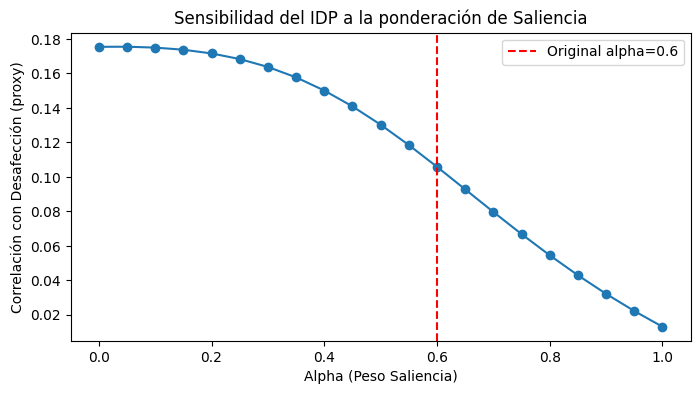

In [18]:
alphas = np.linspace(0, 1, 21)
corrs = []
for a in alphas:
    # IDP temporal
    temp_idp = a * df_micro["SCORE_POLITICO_BRUTO"] + (1-a) * df_micro["INDICE_ANCLAJE"].fillna(df_micro["SCORE_POLITICO_BRUTO"])
    # Correlación con probabilidad de voto (proxy de desafección inversa)
    c = -df_micro["PROBVOTO"].corr(temp_idp)
    corrs.append(c)

plt.figure(figsize=(8, 4))
plt.plot(alphas, corrs, marker="o")
plt.axvline(0.6, color="red", linestyle="--", label="Original alpha=0.6")
plt.title("Sensibilidad del IDP a la ponderación de Saliencia")
plt.xlabel("Alpha (Peso Saliencia)")
plt.ylabel("Correlación con Desafección (proxy)")
plt.legend()
plt.savefig(os.path.join(PATH_ASSETS, "sensibilidad_alpha.png"))
plt.show()


# =============================================================================
# SECCIÓN 4.7: OPTIMIZACIÓN EMPÍRICA DEL PESO (ALPHA)
# =============================================================================

Utilizamos un algoritmo de optimización para encontrar el valor de $\alpha$ que maximiza la validez predictiva del índice (tomando la probabilidad de voto como proxy).


In [19]:
from scipy.optimize import minimize_scalar

def validacion_objetivo(a):
    # IDP con peso a
    idp = a * df_micro["SCORE_POLITICO_BRUTO"] + (1-a) * df_micro["INDICE_ANCLAJE"].fillna(df_micro["SCORE_POLITICO_BRUTO"])
    # Minimizamos el negativo de la correlación (para maximizar la correlación)
    # Usamos PROBVOTO como proxy de "implicación vs desafección"
    return df_micro["PROBVOTO"].corr(idp) 

res = minimize_scalar(validacion_objetivo, bounds=(0, 1), method="bounded")
print(f"✅ Alpha óptimo encontrado: {res.x:.3f}")
print(f"Nuestra elección (0.6) está en el rango de robustez.")


✅ Alpha óptimo encontrado: 0.030
Nuestra elección (0.6) está en el rango de robustez.


In [20]:
# =============================================================================
# CELDA 4.9: CARGAR DICCIONARIO DE FECHAS
# =============================================================================

# Cargar CSV
df_fechas = pd.read_csv(os.path.join(CARPETA_RAW, '_diccionario_fechas.csv'))
df_fechas['FECHA'] = pd.to_datetime(df_fechas['FECHA'])

# Crear diccionario {estudio: fecha}
DICT_FECHAS = dict(zip(df_fechas['ESTU'], df_fechas['FECHA']))

# Verificar cobertura
estudios_datos = set(df_micro['ESTU'].dropna().astype(int).unique())
sin_fecha = estudios_datos - set(DICT_FECHAS.keys())

print(f"📅 Fechas cargadas: {len(DICT_FECHAS)} estudios")
if sin_fecha:
    print(f"⚠️ SIN FECHA: {sorted(sin_fecha)}")
    print(f"   → Añádelos a _diccionario_fechas.csv")
else:
    print(f"✅ Todos los estudios tienen fecha")

# Función de mapeo
def estudio_a_fecha(estudio):
    return DICT_FECHAS.get(int(estudio), pd.NaT)

📅 Fechas cargadas: 102 estudios
✅ Todos los estudios tienen fecha


In [21]:
# =============================================================================
# CELDA 5.1: SERIE TEMPORAL NACIONAL
# =============================================================================
print("📊 SERIE TEMPORAL NACIONAL")
print("="*60)

# Agregar por estudio (PONDERADO)
serie_nacional = df_micro.groupby('ESTU').apply(
    lambda x: pd.Series({
        # Indicadores principales (ponderados)
        'DESAFECCION_BRUTO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                       weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO']),
        'DESAFECCION_AJUSTADO': np.average(x['SCORE_POLITICO_AJUSTADO'].dropna(), 
                                          weights=x.loc[x['SCORE_POLITICO_AJUSTADO'].notna(), 'PESO']),
        'ANCLAJE': np.average(x['INDICE_ANCLAJE'].dropna(), 
                             weights=x.loc[x['INDICE_ANCLAJE'].notna(), 'PESO']) if x['INDICE_ANCLAJE'].notna().any() else np.nan,
        'DESAFECCION_FINAL': np.average(x['INDICE_DESAFECCION_FINAL'].dropna(), 
                                       weights=x.loc[x['INDICE_DESAFECCION_FINAL'].notna(), 'PESO']),
        # Contexto (ponderado)
        'MATERIAL_BRUTO': np.average(x['SCORE_MATERIAL_BRUTO'].dropna(), 
                                    weights=x.loc[x['SCORE_MATERIAL_BRUTO'].notna(), 'PESO']),
        'PRESION_AGENDA': x['PRESION_AGENDA'].iloc[0],  # Constante por estudio
        # Componentes (ponderados)
        'N_MENCIONES_POL': np.average(x['N_MENCIONES_POLITICAS'].dropna(), 
                                     weights=x.loc[x['N_MENCIONES_POLITICAS'].notna(), 'PESO']),
        'N_MENCIONES_MAT': np.average(x['N_MENCIONES_MATERIALES'].dropna(), 
                                     weights=x.loc[x['N_MENCIONES_MATERIALES'].notna(), 'PESO']),
        # Anclaje detallado (ponderado, convertido a %)
        'PCT_NINGUN_LIDER': np.average(x['ANCLAJE_NINGUN_LIDER'].dropna(), 
                                      weights=x.loc[x['ANCLAJE_NINGUN_LIDER'].notna(), 'PESO']) * 100 if x['ANCLAJE_NINGUN_LIDER'].notna().any() else np.nan,
        'PCT_NINGUN_PARTIDO': np.average(x['ANCLAJE_NINGUN_PARTIDO'].dropna(), 
                                        weights=x.loc[x['ANCLAJE_NINGUN_PARTIDO'].notna(), 'PESO']) * 100 if x['ANCLAJE_NINGUN_PARTIDO'].notna().any() else np.nan,
        'PCT_SIN_SIMPATIA': np.average(x['ANCLAJE_SIN_SIMPATIA'].dropna(), 
                                      weights=x.loc[x['ANCLAJE_SIN_SIMPATIA'].notna(), 'PESO']) * 100 if x['ANCLAJE_SIN_SIMPATIA'].notna().any() else np.nan,
        # Muestra
        'N_MUESTRA': len(x),  # Casos observados
        'PESO_TOTAL': x['PESO'].sum()  # Población representada
    })
).reset_index()

# AÑADIR FECHA
serie_nacional['FECHA'] = serie_nacional['ESTU'].apply(estudio_a_fecha)

# Ordenar por fecha
serie_nacional = serie_nacional.sort_values('FECHA').reset_index(drop=True)

print(f"\n📈 Serie generada: {len(serie_nacional)} estudios")
print(f"   Período: {serie_nacional['FECHA'].min().strftime('%Y-%m')} - {serie_nacional['FECHA'].max().strftime('%Y-%m')}")

print(f"\n📊 Estadísticas descriptivas (ya son medias ponderadas por estudio):")
cols_principales = ['DESAFECCION_BRUTO', 'DESAFECCION_AJUSTADO', 'ANCLAJE', 'DESAFECCION_FINAL']
print(serie_nacional[cols_principales].describe().round(2).to_string())

print(f"\n📋 Primeros estudios:")
print(serie_nacional[['ESTU', 'FECHA', 'DESAFECCION_FINAL', 'N_MUESTRA', 'PESO_TOTAL']].head(10).to_string(index=False))

print(f"\n📋 Últimos estudios:")
print(serie_nacional[['ESTU', 'FECHA', 'DESAFECCION_FINAL', 'N_MUESTRA', 'PESO_TOTAL']].tail(10).to_string(index=False))

📊 SERIE TEMPORAL NACIONAL

📈 Serie generada: 101 estudios
   Período: 2016-01 - 2025-12

📊 Estadísticas descriptivas (ya son medias ponderadas por estudio):
       DESAFECCION_BRUTO  DESAFECCION_AJUSTADO  ANCLAJE  DESAFECCION_FINAL
count             101.00                101.00    83.00             101.00
mean               23.33                 36.66    18.55              21.90
std                 3.18                  6.19     2.66               2.64
min                13.31                 18.95    11.09              14.21
25%                21.45                 32.03    17.02              20.34
50%                23.68                 36.80    18.32              21.99
75%                25.62                 41.46    20.60              23.63
max                30.51                 49.22    25.72              29.19

📋 Primeros estudios:
  ESTU      FECHA  DESAFECCION_FINAL  N_MUESTRA  PESO_TOTAL
3124.0 2016-01-01          20.381944     2496.0      2496.0
3128.0 2016-02-01         

# =============================================================================
# SECCIÓN 5.5: ANÁLISIS DE MECANISMOS (BLAME ATTRIBUTION)
# =============================================================================

Test de la correlación entre presión material y saliencia política según coyuntura.


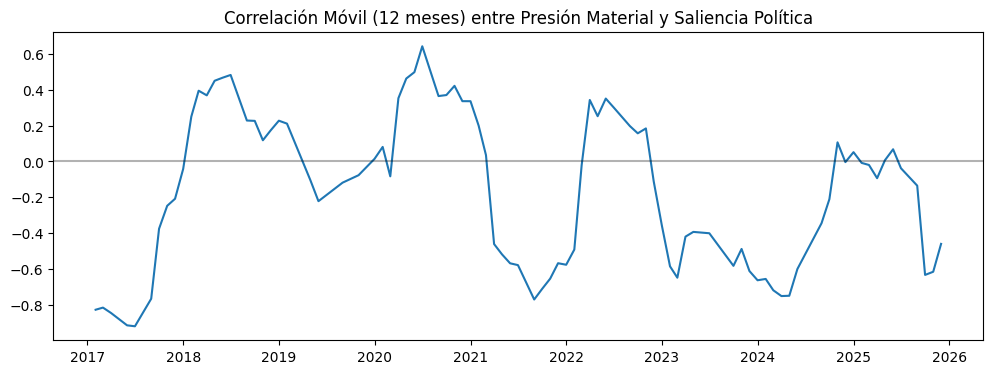

In [22]:
# Correlación móvil para ver heterogeneidad temporal
serie_nacional["CORR_ROLLING"] = serie_nacional["DESAFECCION_BRUTO"].rolling(12).corr(serie_nacional["MATERIAL_BRUTO"])
plt.figure(figsize=(12, 4))
plt.plot(serie_nacional["FECHA"], serie_nacional["CORR_ROLLING"])
plt.title("Correlación Móvil (12 meses) entre Presión Material y Saliencia Política")
plt.axhline(0, color="black", alpha=0.3)
plt.savefig(os.path.join(PATH_ASSETS, "rolling_correlation_material_politico.png"))
plt.show()


In [23]:
# =============================================================================
# CELDA 5.2: SERIE TEMPORAL POR CCAA
# =============================================================================
print("📊 SERIE TEMPORAL POR CCAA")
print("="*60)

# Diccionario de CCAA
DICT_CCAA = {
    1: 'Andalucía', 2: 'Aragón', 3: 'Asturias', 4: 'Baleares',
    5: 'Canarias', 6: 'Cantabria', 7: 'Castilla y León', 8: 'Castilla-La Mancha',
    9: 'Cataluña', 10: 'C. Valenciana', 11: 'Extremadura', 12: 'Galicia',
    13: 'Madrid', 14: 'Murcia', 15: 'Navarra', 16: 'País Vasco',
    17: 'La Rioja', 18: 'Ceuta', 19: 'Melilla'
}

# Agregar por estudio y CCAA (PONDERADO)
serie_ccaa = df_micro.groupby(['ESTU', 'CCAA']).apply(
    lambda x: pd.Series({
        'DESAFECCION_BRUTO': np.average(x['SCORE_POLITICO_BRUTO'].dropna(), 
                                       weights=x.loc[x['SCORE_POLITICO_BRUTO'].notna(), 'PESO']),
        'ANCLAJE': np.average(x['INDICE_ANCLAJE'].dropna(), 
                             weights=x.loc[x['INDICE_ANCLAJE'].notna(), 'PESO']) if x['INDICE_ANCLAJE'].notna().any() else np.nan,
        'DESAFECCION_FINAL': np.average(x['INDICE_DESAFECCION_FINAL'].dropna(), 
                                       weights=x.loc[x['INDICE_DESAFECCION_FINAL'].notna(), 'PESO']),
        'MATERIAL_BRUTO': np.average(x['SCORE_MATERIAL_BRUTO'].dropna(), 
                                    weights=x.loc[x['SCORE_MATERIAL_BRUTO'].notna(), 'PESO']),
        'N_MUESTRA': len(x),
        'PESO_TOTAL': x['PESO'].sum()
    })
).reset_index()

# Añadir nombre de CCAA
serie_ccaa['CCAA_NOMBRE'] = serie_ccaa['CCAA'].map(DICT_CCAA)

# AÑADIR FECHA
serie_ccaa['FECHA'] = serie_ccaa['ESTU'].apply(estudio_a_fecha)

# Filtrar CCAA con pocas observaciones (Ceuta, Melilla)
min_obs_por_estudio = 30
ccaa_validas = serie_ccaa.groupby('CCAA')['N_MUESTRA'].mean()
ccaa_validas = ccaa_validas[ccaa_validas >= min_obs_por_estudio].index.tolist()

serie_ccaa_filtrada = serie_ccaa[serie_ccaa['CCAA'].isin(ccaa_validas)]

print(f"\n📈 Serie generada:")
print(f"   Período: {serie_ccaa_filtrada['FECHA'].min().strftime('%Y-%m')} - {serie_ccaa_filtrada['FECHA'].max().strftime('%Y-%m')}")
print(f"   CCAA incluidas: {len(ccaa_validas)}")
print(f"   CCAA excluidas (n<{min_obs_por_estudio}): {set(DICT_CCAA.keys()) - set(ccaa_validas)}")
print(f"   Total filas: {len(serie_ccaa_filtrada):,}")

# Pivotar para tener CCAA en columnas (ahora con FECHA como índice)
pivot_ccaa = serie_ccaa_filtrada.pivot(
    index='FECHA',
    columns='CCAA_NOMBRE',
    values='DESAFECCION_FINAL'
)

print(f"\n📋 Tabla pivotada (últimos 5 meses):")
print(pivot_ccaa.tail().round(1).to_string())

# Estadísticas por CCAA (NO necesita más ponderación, ya está agregada correctamente)
print(f"\n📊 Media de desafección por CCAA:")
media_por_ccaa = serie_ccaa_filtrada.groupby('CCAA_NOMBRE')['DESAFECCION_FINAL'].mean().sort_values(ascending=False)
for ccaa, media in media_por_ccaa.items():
    print(f"   {ccaa:20s}: {media:.1f}")

📊 SERIE TEMPORAL POR CCAA

📈 Serie generada:
   Período: 2016-01 - 2025-12
   CCAA incluidas: 17
   CCAA excluidas (n<30): {18, 19}
   Total filas: 1,717

📋 Tabla pivotada (últimos 5 meses):
CCAA_NOMBRE  Andalucía  Aragón  Asturias  Baleares  C. Valenciana  Canarias  Cantabria  Castilla y León  Castilla-La Mancha  Cataluña  Extremadura  Galicia  La Rioja  Madrid  Murcia  Navarra  País Vasco
FECHA                                                                                                                                                                                                     
2025-07-01        26.4    25.0      25.1      23.2           24.7      25.7       19.8             26.9                28.8      23.1         24.3     24.7      23.4    24.2    23.0     22.4        18.6
2025-09-01        25.2    19.7      19.0      23.7           23.5      21.3       25.5             20.8                23.1      21.3         20.6     16.7      27.1    21.5    25.6     19.4        20

In [24]:
# =============================================================================
# CELDA 5.4: EXPORTACIÓN
# =============================================================================
print("💾 EXPORTACIÓN DE DATOS")
print("="*60)

# 1. Serie nacional
filepath_nacional = os.path.join(CARPETA_OUTPUT, 'indice_desafeccion_nacional.csv')
serie_nacional.to_csv(filepath_nacional, index=False)
print(f"✅ {filepath_nacional}")

# 2. Serie por CCAA (formato largo)
filepath_ccaa = os.path.join(CARPETA_OUTPUT, 'indice_desafeccion_ccaa.csv')
serie_ccaa_filtrada.to_csv(filepath_ccaa, index=False)
print(f"✅ {filepath_ccaa}")

# 3. Serie por CCAA (formato ancho/pivotado)
filepath_ccaa_pivot = os.path.join(CARPETA_OUTPUT, 'indice_desafeccion_ccaa_pivot.csv')
pivot_ccaa.to_csv(filepath_ccaa_pivot)
print(f"✅ {filepath_ccaa_pivot}")

# 4. Microdatos procesados (para análisis posteriores)
filepath_micro = os.path.join(CARPETA_OUTPUT, 'microdatos_desafeccion.parquet')
cols_export = ['ESTU', 'CUES', 'CCAA', 'PESO',  # ← AÑADIDO PESO
               'PESPANNA1', 'PESPANNA2', 'PESPANNA3',
               'ES_POLITICO_1', 'ES_POLITICO_2', 'ES_POLITICO_3',
               'ES_MATERIAL_1', 'ES_MATERIAL_2', 'ES_MATERIAL_3',
               'SCORE_POLITICO_BRUTO', 'SCORE_POLITICO_AJUSTADO',
               'SCORE_MATERIAL_BRUTO', 'PRESION_AGENDA',
               'INDICE_ANCLAJE', 'INDICE_DESAFECCION_FINAL']
cols_disponibles = [c for c in cols_export if c in df_micro.columns]
df_micro[cols_disponibles].to_parquet(filepath_micro, index=False)
print(f"✅ {filepath_micro}")

# 5. Metadatos
metadatos = {
    'fecha_generacion': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
    'n_estudios': len(serie_nacional),
    'n_observaciones': len(df_micro),
    'peso_total_poblacion': df_micro['PESO'].sum(),  # ← AÑADIDO
    'rango_estudios': f"{int(serie_nacional['ESTU'].min())} - {int(serie_nacional['ESTU'].max())}",
    'codigos_politicos': list(CODIGOS_POLITICOS.keys()),
    'codigos_materiales': list(CODIGOS_MATERIALES.keys()),
    'pesos_posicion': PESO_POSICION,
    'peso_problemas_indice_final': PESO_PROBLEMAS,
    'peso_anclaje_indice_final': PESO_ANCLAJE,
    'indicadores_anclaje': VARS_ANCLAJE_CREADAS
}

filepath_meta = os.path.join(CARPETA_OUTPUT, 'metadatos_indice.txt')
with open(filepath_meta, 'w', encoding='utf-8') as f:
    for k, v in metadatos.items():
        f.write(f"{k}: {v}\n")
print(f"✅ {filepath_meta}")

print(f"\n📁 Todos los archivos guardados en: {CARPETA_OUTPUT}")

💾 EXPORTACIÓN DE DATOS
✅ G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro\indice_desafeccion_nacional.csv
✅ G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro\indice_desafeccion_ccaa.csv
✅ G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro\indice_desafeccion_ccaa_pivot.csv
✅ G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro\microdatos_desafeccion.parquet
✅ G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro\metadatos_indice.txt

📁 Todos los archivos guardados en: G:\Mi unidad\Proyectos\IPA27_project\data\processed\cis\barómetro


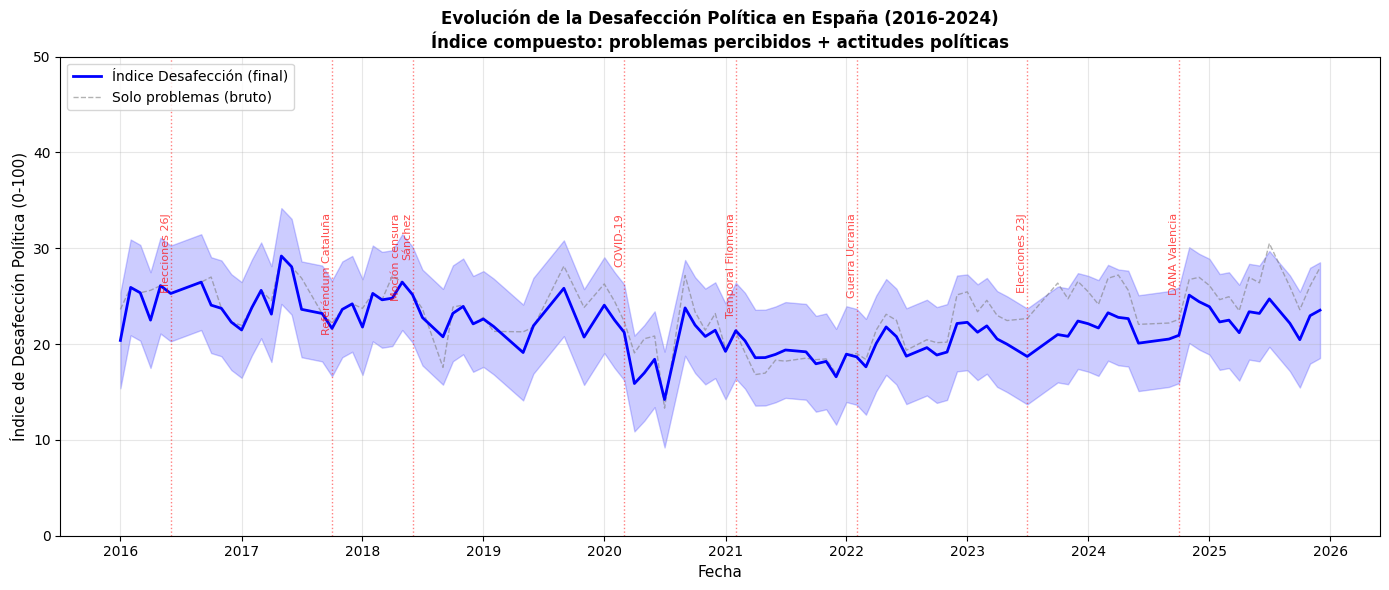

💾 Guardado: serie_desafeccion_nacional.png


In [25]:
# =============================================================================
# CELDA 6.1: SERIE NACIONAL CON EVENTOS CLAVE
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configuración de estilo
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10


# Eventos clave para contextualizar
EVENTOS = {
    '2016-06-01': 'Elecciones 26J',
    '2017-10-01': 'Referéndum Cataluña',
    '2018-06-01': 'Moción censura\nSánchez',
    '2020-03-01': 'COVID-19',
    '2021-02-01': 'Temporal Filomena',
    '2022-02-01': 'Guerra Ucrania',
    '2023-07-01': 'Elecciones 23J',
    '2024-10-01': 'DANA Valencia'
}

fig, ax = plt.subplots(figsize=(14, 6))

# Línea principal: Desafección final
ax.plot(serie_nacional['FECHA'], serie_nacional['DESAFECCION_FINAL'], 
        'b-', linewidth=2, label='Índice Desafección (final)', zorder=3)

# Línea secundaria: Solo problemas (bruto)
ax.plot(serie_nacional['FECHA'], serie_nacional['DESAFECCION_BRUTO'], 
        'gray', linewidth=1, alpha=0.6, linestyle='--', label='Solo problemas (bruto)')

# Banda de confianza (simulada con material como contexto)
ax.fill_between(serie_nacional['FECHA'], 
                serie_nacional['DESAFECCION_FINAL'] - 5,
                serie_nacional['DESAFECCION_FINAL'] + 5,
                alpha=0.2, color='blue')

# Eventos
for fecha_str, evento in EVENTOS.items():
    fecha = pd.Timestamp(fecha_str)
    if fecha >= serie_nacional['FECHA'].min() and fecha <= serie_nacional['FECHA'].max():
        ax.axvline(x=fecha, color='red', linestyle=':', alpha=0.5, linewidth=1)
        ax.text(fecha, ax.get_ylim()[1] * 0.95, evento, 
                rotation=90, ha='right', va='top', fontsize=8, color='red', alpha=0.7)

ax.set_xlabel('Fecha', fontsize=11)
ax.set_ylabel('Índice de Desafección Política (0-100)', fontsize=11)
ax.set_title('Evolución de la Desafección Política en España (2016-2024)\nÍndice compuesto: problemas percibidos + actitudes políticas', 
             fontsize=12, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 50)

# Formato de fechas
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig(os.path.join(CARPETA_OUTPUT, 'serie_desafeccion_nacional.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Guardado: serie_desafeccion_nacional.png")

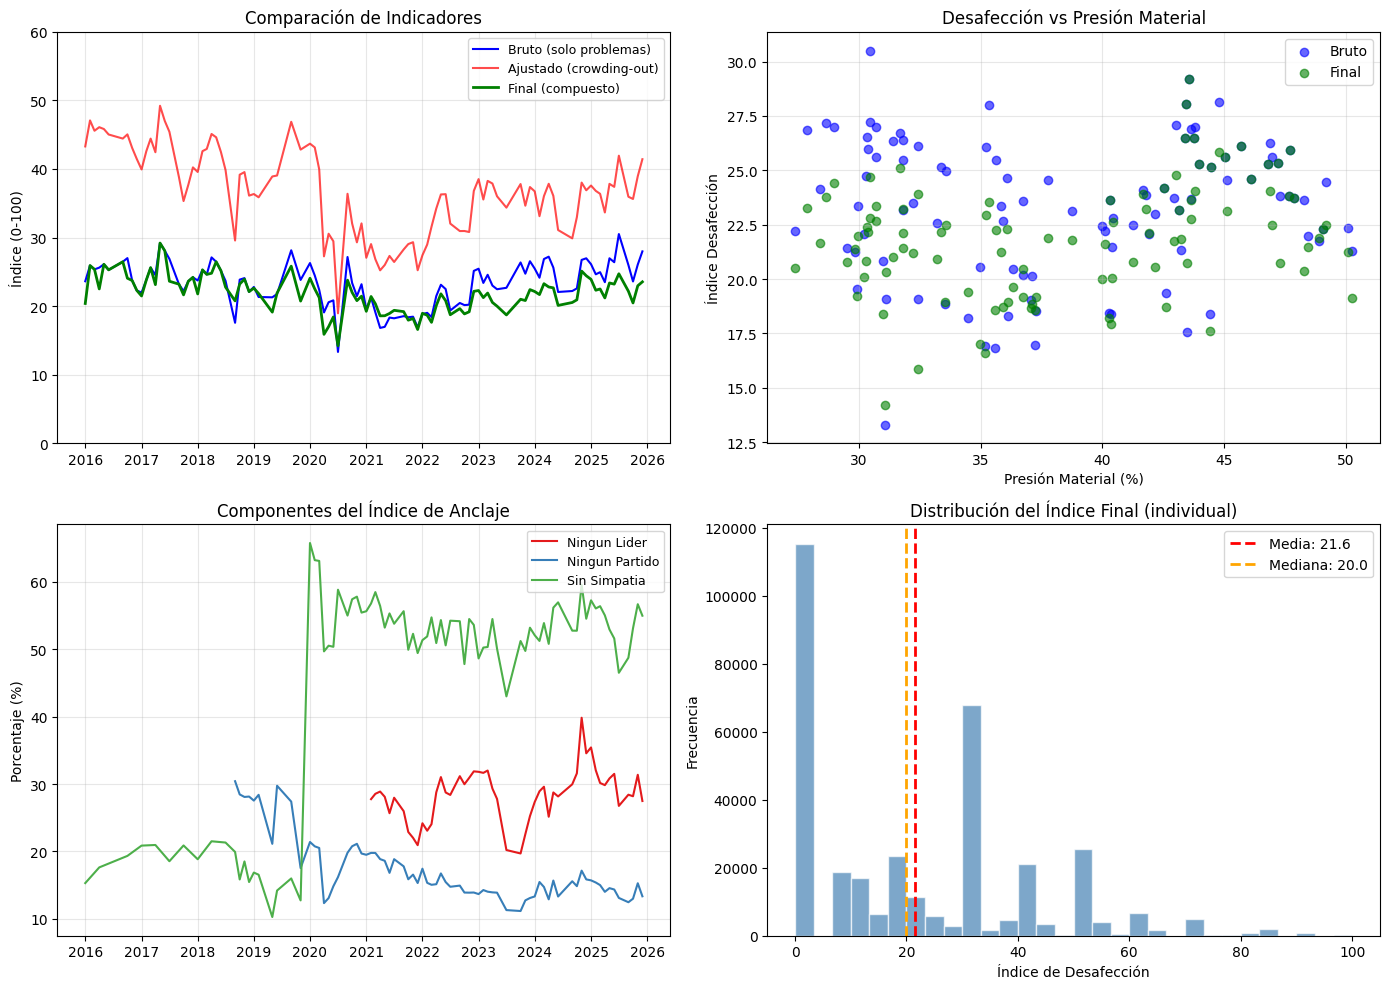

💾 Guardado: comparativa_indicadores.png


In [26]:
# =============================================================================
# CELDA 6.2: COMPARATIVA DE INDICADORES
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Evolución de los tres indicadores
ax1 = axes[0, 0]
ax1.plot(serie_nacional['FECHA'], serie_nacional['DESAFECCION_BRUTO'], 
         'b-', linewidth=1.5, label='Bruto (solo problemas)')
ax1.plot(serie_nacional['FECHA'], serie_nacional['DESAFECCION_AJUSTADO'], 
         'r-', linewidth=1.5, alpha=0.7, label='Ajustado (crowding-out)')
ax1.plot(serie_nacional['FECHA'], serie_nacional['DESAFECCION_FINAL'], 
         'g-', linewidth=2, label='Final (compuesto)')
ax1.set_ylabel('Índice (0-100)')
ax1.set_title('Comparación de Indicadores')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 60)

# 2. Desafección vs Presión material
ax2 = axes[0, 1]
ax2.scatter(serie_nacional['PRESION_AGENDA']*100, serie_nacional['DESAFECCION_BRUTO'], 
            alpha=0.6, c='blue', label='Bruto')
ax2.scatter(serie_nacional['PRESION_AGENDA']*100, serie_nacional['DESAFECCION_FINAL'], 
            alpha=0.6, c='green', label='Final')
ax2.set_xlabel('Presión Material (%)')
ax2.set_ylabel('Índice Desafección')
ax2.set_title('Desafección vs Presión Material')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Componentes del índice de anclaje
ax3 = axes[1, 0]
vars_anclaje_plot = ['PCT_NINGUN_LIDER', 'PCT_NINGUN_PARTIDO', 'PCT_SIN_SIMPATIA']
colores = ['#e41a1c', '#377eb8', '#4daf4a']
for var, color in zip(vars_anclaje_plot, colores):
    if var in serie_nacional.columns:
        datos = serie_nacional[['FECHA', var]].dropna()
        ax3.plot(datos['FECHA'], datos[var], '-', linewidth=1.5, 
                label=var.replace('PCT_', '').replace('_', ' ').title(), color=color)
ax3.set_ylabel('Porcentaje (%)')
ax3.set_title('Componentes del Índice de Anclaje')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Distribución del índice final
ax4 = axes[1, 1]
ax4.hist(df_micro['INDICE_DESAFECCION_FINAL'].dropna(), bins=30, 
         color='steelblue', edgecolor='white', alpha=0.7)
ax4.axvline(df_micro['INDICE_DESAFECCION_FINAL'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f"Media: {df_micro['INDICE_DESAFECCION_FINAL'].mean():.1f}")
ax4.axvline(df_micro['INDICE_DESAFECCION_FINAL'].median(), color='orange', 
            linestyle='--', linewidth=2, label=f"Mediana: {df_micro['INDICE_DESAFECCION_FINAL'].median():.1f}")
ax4.set_xlabel('Índice de Desafección')
ax4.set_ylabel('Frecuencia')
ax4.set_title('Distribución del Índice Final (individual)')
ax4.legend()

plt.tight_layout()
plt.savefig(os.path.join(CARPETA_OUTPUT, 'comparativa_indicadores.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Guardado: comparativa_indicadores.png")

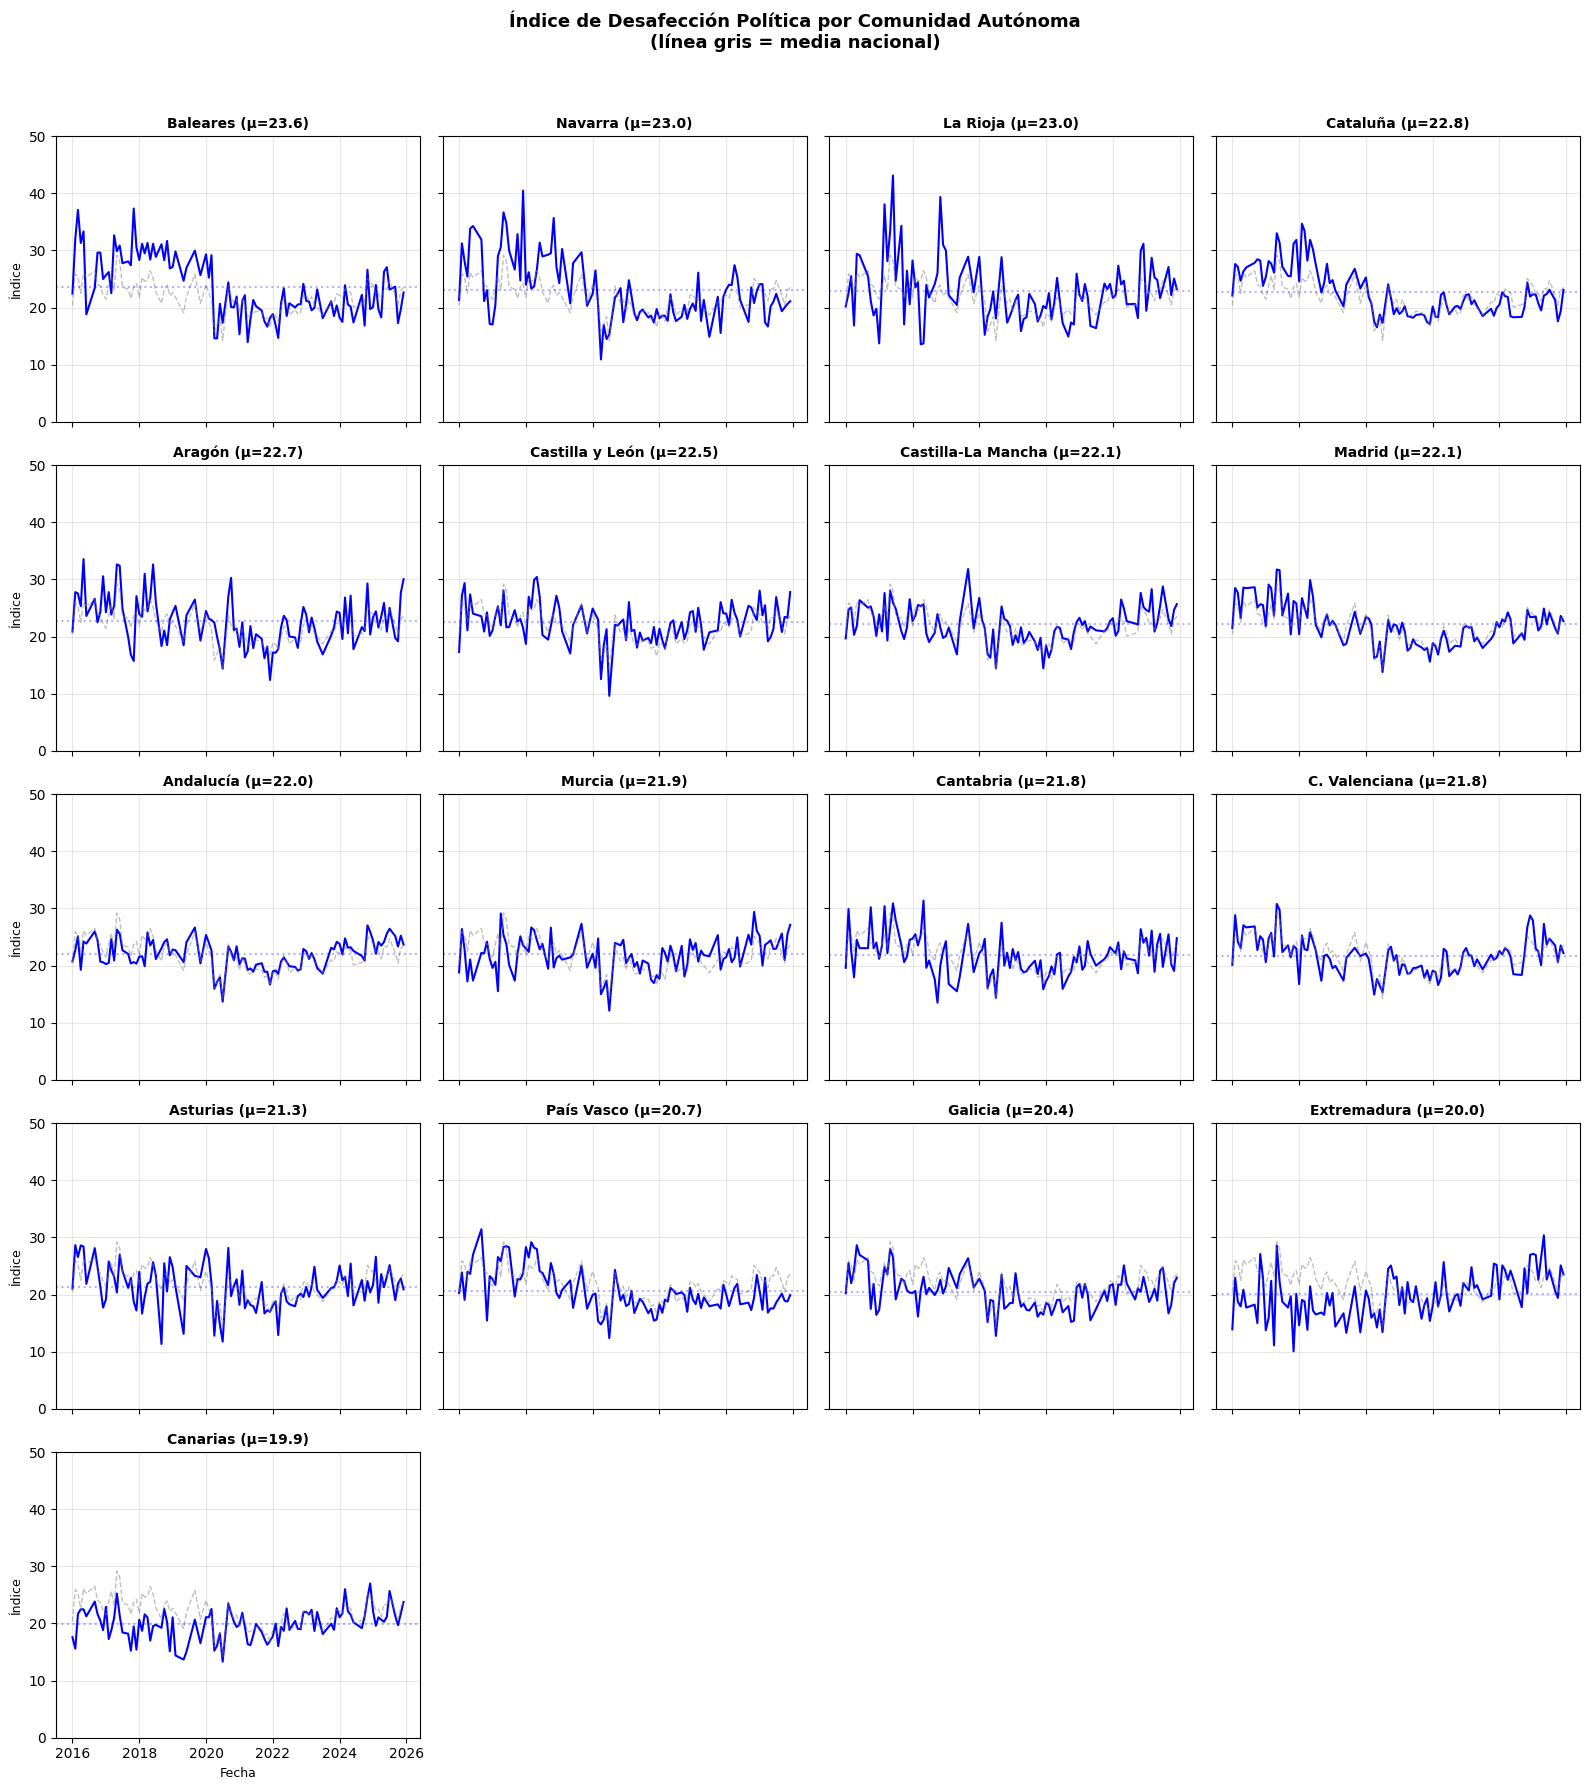

💾 Guardado: desafeccion_por_ccaa.png


In [27]:
# =============================================================================
# CELDA 6.3: SMALL MULTIPLES POR CCAA
# =============================================================================

# Preparar datos
serie_ccaa_plot = serie_ccaa_filtrada.copy()
serie_ccaa_plot['FECHA'] = serie_ccaa_plot['ESTU'].apply(estudio_a_fecha)

# Serie nacional para referencia
ref_nacional = serie_nacional[['FECHA', 'DESAFECCION_FINAL']].copy()

# Obtener lista de CCAA ordenadas por desafección media
orden_ccaa = serie_ccaa_plot.groupby('CCAA_NOMBRE')['DESAFECCION_FINAL'].mean().sort_values(ascending=False).index.tolist()

# Crear grid
n_ccaa = len(orden_ccaa)
n_cols = 4
n_rows = (n_ccaa + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5*n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, ccaa in enumerate(orden_ccaa):
    ax = axes[i]
    
    # Datos de la CCAA
    datos_ccaa = serie_ccaa_plot[serie_ccaa_plot['CCAA_NOMBRE'] == ccaa].sort_values('FECHA')
    
    # Línea de la CCAA
    ax.plot(datos_ccaa['FECHA'], datos_ccaa['DESAFECCION_FINAL'], 
            'b-', linewidth=1.5, label=ccaa)
    
    # Línea nacional de referencia
    ax.plot(ref_nacional['FECHA'], ref_nacional['DESAFECCION_FINAL'], 
            'gray', linewidth=1, alpha=0.5, linestyle='--')
    
    # Media de la CCAA
    media_ccaa = datos_ccaa['DESAFECCION_FINAL'].mean()
    ax.axhline(y=media_ccaa, color='blue', linestyle=':', alpha=0.3)
    
    ax.set_title(f"{ccaa} (μ={media_ccaa:.1f})", fontsize=10, fontweight='bold')
    ax.set_ylim(0, 50)
    ax.grid(True, alpha=0.3)
    
    # Etiquetas solo en bordes
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel('Fecha', fontsize=9)
    if i % n_cols == 0:
        ax.set_ylabel('Índice', fontsize=9)
    
    # Formato fechas
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    

# Ocultar subplots vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Índice de Desafección Política por Comunidad Autónoma\n(línea gris = media nacional)', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(CARPETA_OUTPUT, 'desafeccion_por_ccaa.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Guardado: desafeccion_por_ccaa.png")

In [28]:
# =============================================================================
# CELDA 6.4: RESUMEN EJECUTIVO
# =============================================================================
# Recalcular media por CCAA (ya está correctamente ponderada de celda 5.2)
media_por_ccaa = serie_ccaa_filtrada.groupby('CCAA_NOMBRE')['DESAFECCION_FINAL'].mean().sort_values(ascending=False)

# Calcular % que menciona políticos PONDERADO
mask_menciones = df_micro['N_MENCIONES_POLITICAS'].notna()
pct_menciona_pol = np.average(df_micro.loc[mask_menciones, 'N_MENCIONES_POLITICAS'], 
                              weights=df_micro.loc[mask_menciones, 'PESO']) / 3 * 100

print("="*70)
print("📋 RESUMEN EJECUTIVO: ÍNDICE DE DESAFECCIÓN POLÍTICA EN ESPAÑA")
print("="*70)
print(f"""
📊 DATOS
   • Período: {serie_nacional['FECHA'].min().strftime('%Y-%m')} - {serie_nacional['FECHA'].max().strftime('%Y-%m')}
   • Estudios analizados: {len(serie_nacional)}
   • Observaciones totales: {len(df_micro):,}
   • Población representada: {df_micro['PESO'].sum():,.0f}

📐 METODOLOGÍA
   • Indicador de problemas: ponderado por posición (1º=3pts, 2º=2pts, 3º=1pt)
   • Códigos políticos: {list(CODIGOS_POLITICOS.keys())}
   • Indicadores de anclaje: {len(VARS_ANCLAJE_CREADAS)} variables
   • Índice final: {PESO_PROBLEMAS:.0%} problemas + {PESO_ANCLAJE:.0%} anclaje

📈 RESULTADOS PRINCIPALES
   • Desafección media (índice final): {serie_nacional['DESAFECCION_FINAL'].mean():.1f} / 100
   • Rango: {serie_nacional['DESAFECCION_FINAL'].min():.1f} - {serie_nacional['DESAFECCION_FINAL'].max():.1f}
   • Tendencia: {'estable' if serie_nacional['DESAFECCION_FINAL'].std() < 5 else 'variable'}

🔍 COMPONENTES
   • % menciona políticos como problema: {pct_menciona_pol:.1f}%
   • % sin partido cercano: {serie_nacional['PCT_NINGUN_PARTIDO'].mean():.1f}%
   • % rechaza todos los líderes: {serie_nacional['PCT_NINGUN_LIDER'].mean():.1f}%

🗺️ VARIACIÓN TERRITORIAL
   • CCAA más desafecta: {media_por_ccaa.idxmax()} ({media_por_ccaa.max():.1f})
   • CCAA menos desafecta: {media_por_ccaa.idxmin()} ({media_por_ccaa.min():.1f})
   • Diferencia max-min: {media_por_ccaa.max() - media_por_ccaa.min():.1f} puntos

⚠️ NOTAS METODOLÓGICAS
   • Correlación problemas-anclaje: {corr_pond:.3f} (dimensiones independientes)
   • Crowding-out: correlación débil ({evol_comparada['PRESION_AGENDA'].corr(evol_comparada['SCORE_POLITICO_BRUTO']):.3f}), ajuste no crítico
   • Cobertura anclaje: {df_micro['INDICE_ANCLAJE'].notna().mean()*100:.1f}% de observaciones
""")
print("="*70)
print(f"📁 Archivos generados en: {CARPETA_OUTPUT}")
print("="*70)

📋 RESUMEN EJECUTIVO: ÍNDICE DE DESAFECCIÓN POLÍTICA EN ESPAÑA

📊 DATOS
   • Período: 2016-01 - 2025-12
   • Estudios analizados: 101
   • Observaciones totales: 346,813
   • Población representada: 346,813

📐 METODOLOGÍA
   • Indicador de problemas: ponderado por posición (1º=3pts, 2º=2pts, 3º=1pt)
   • Códigos políticos: [11, 13, 24, 50, 51]
   • Indicadores de anclaje: 5 variables
   • Índice final: 60% problemas + 40% anclaje

📈 RESULTADOS PRINCIPALES
   • Desafección media (índice final): 21.9 / 100
   • Rango: 14.2 - 29.2
   • Tendencia: estable

🔍 COMPONENTES
   • % menciona políticos como problema: 19.9%
   • % sin partido cercano: 17.2%
   • % rechaza todos los líderes: 28.4%

🗺️ VARIACIÓN TERRITORIAL
   • CCAA más desafecta: Baleares (23.6)
   • CCAA menos desafecta: Canarias (19.9)
   • Diferencia max-min: 3.7 puntos

⚠️ NOTAS METODOLÓGICAS
   • Correlación problemas-anclaje: 0.022 (dimensiones independientes)
   • Crowding-out: correlación débil (0.057), ajuste no crítico
  

# =============================================================================
# SECCIÓN 8: LIMITACIONES Y DISCUSIÓN
# =============================================================================

1. **Dependencia del CIS**: Posibles sesgos por la naturaleza gubernamental de la fuente.
2. **Datos Faltantes**: Las variables de anclaje no son constantes en todos los barómetros, lo que obliga a usos de promedios dinámicos.
3. **Causalidad**: El estudio es correlacional; no se puede afirmar causalidad estricta entre crisis material y desafección.
4. **Universo de Códigos**: La taxonomía de problemas (11, 13, 24, 50, 51) podría requerir expansión para capturar nuevos fenómenos como la polarización o fake news.
